In [594]:
import torch
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import DataLoader
from torch.autograd import Variable
from tqdm import tqdm
import numpy as np
from CGRtools import smiles
from optparse import OptionParser
from collections import deque
from IPython.display import clear_output
from Levenshtein import distance as Lev
from math import pi
from jtnn import *
import rdkit
from rdkit import Chem

    
lg = rdkit.RDLogger.logger() 
lg.setLevel(rdkit.RDLogger.CRITICAL)

In [6]:
from zipfile import ZipFile

In [7]:
zipObj = ZipFile('marians.zip', 'w')
# Add multiple files to the zip
zipObj.write('Marians/train.csv')
zipObj.write('Marians/test.csv')
zipObj.write('Marians/val.csv')
zipObj.write('Marians/show_mols.ipynb')
# close the Zip File
zipObj.close()

In [8]:
from warnings import filterwarnings
filterwarnings("ignore")

## Functions and constants

In [9]:
def get_coefficient(molecules, model, regressor):
    model.eval()
    with torch.no_grad():
        
        encodings = model.encode_latent_mean(molecules)
        return regressor(encodings)

In [49]:
def latent_space_descent(variables, target, regressor, loss, opt, n_steps = 1):
    regressor.train()
        
    for i in range(n_steps):
        regressor.zero_grad()
        opt.zero_grad()
        
        prediction = regressor(variables)
        wloss = loss(prediction, target)
        wloss.backward()
        opt.step()
        
    return prediction.cpu().detach().numpy()

def latent_space_descent_two_proprieties(variables, target, regression, loss, opt, n_steps = 1):
    regressor.eval()
    props = (torch.ones(variables.size()[0], 1)*target).cuda()
        
    for i in range(n_steps):
        regressor.zero_grad()
        opt.zero_grad()
        
        prediction = regressor(variables)
        wloss = loss(prediction, props)
        wloss.backward()
        opt.step()
        
    return prediction.cpu().detach().numpy()

def visualise(variables, properties, model):
    tree_vec, mol_vec = torch.split(variables, variables.size()[1]//2, 1)
    
    s = []
    for i, (tree, mol) in enumerate(zip(tree_vec, mol_vec)):
        _s = smiles(model.decode(tree[None, :],mol[None, :], False))
        _s.clean_stereo()
        _s.canonicalize()

        s.append(_s.__str__())
        
    for i, mol in enumerate(s):
        print("Generated molecule: {} with predicted coeficient {:.3f}".format(mol, properties[i][0]))
        
def latent_space_descent_m(variables, target, regression, loss, opt, n_steps = 1):
    regressor.train()
    props = (torch.ones(variables.size()[0], target.shape[0])*target).cuda()
        
    for i in range(n_steps):
        regressor.zero_grad()
        opt.zero_grad()
        
        prediction = regressor(variables)
        wloss = loss(prediction, props)
        wloss = wloss.sum(dim=1).mean(dim=0)
        wloss.backward()
        opt.step()
        
    return prediction.cpu().detach().numpy()

def visualise_m(variables, properties, model):  
    
    tree_vec, mol_vec = torch.split(variables, variables.size()[1]//2, 1)
    
    s = []
    for i, (tree, mol) in enumerate(zip(tree_vec, mol_vec)):
        _s = smiles(model.decode(tree[None, :],mol[None, :], False))
        _s.clean_stereo()
        _s.canonicalize()

        s.append(_s.__str__())

    for i, mol in enumerate(s):
        print("Generated molecule: {} with predicted coeficient".format(mol), end=" ")
        for prop in properties[i]:
            print("{:.3f}".format(prop), end=" ")
        print(" ")
        
def init_latent_vector(size, example=None):
    if example is not None:
        return torch.tensor(example + torch.rand(size, device="cuda"), requires_grad=True)

    else:
        return torch.rand(size, device="cuda", requires_grad=True)
    
def show_molecules(smiles, props, target):
    row = math.ceil(len(smiles)/3)
    column = 3

    plt.figure(figsize=(18, 6*row))
    for i, mol in enumerate(smiles):
        position = 1 + i
        img = Chem.Draw.MolToImage(Chem.MolFromSmiles(mol))

        ax = plt.subplot(row, column, position)
        title = mol + "\n"
        for key, value in props.items():
            title += "{}: {:.4f}\n".format(key, value[i])
            
        if target is not None:
            mse = value
            for k, (key, value) in enumerate(props.items()):
                title += "MSE value for {}: {:.4f}\n".format(key, abs(value[i] - target[k]))
        ax.set_title(title)
        ax.axis("off")
        ax.imshow(img)

    plt.show()
    
def display_mol_tree(node, prefix="", visited=set()):
    visited.add(node.nid)
    ns = node.neighbors
    
    if len(ns) >= 1:
        print(prefix, node.smiles, f"[id{node.nid}]")
        for i, child in enumerate(ns):
            
            if child.nid in visited:
                continue
            
            prefix = prefix.replace("├──", "│   ")
            prefix = prefix.replace("└──", "     ")
            
            if i == len(ns) - 1:
                display_mol_tree(child, prefix+" └──", visited)
            else:
                display_mol_tree(child, prefix+" ├──", visited)
    else:
        print(prefix, node.smiles, f"[id{node.nid}]")
        
def clean(smls):
    mol = smiles(smls)
    mol.clean_stereo()
    mol.canonicalize()
    return mol.__str__()

def predict_decode_predict(molecules, model, regressor):
    df = pd.DataFrame()
    with torch.no_grad():
        before = regressor(molecules).cpu().numpy()

        tree_vec, mol_vec = torch.split(molecules, molecules.size()[1]//2, 1)
        s = []
        for i, (tree, mol) in enumerate(zip(tree_vec, mol_vec)):
            _s = smiles(model.decode(tree[None, :],mol[None, :], False))
            _s.clean_stereo()
            _s.canonicalize()

            s.append(_s.__str__())
            
        after = get_coefficient(s, model, regressor).cpu().numpy()

    return pd.DataFrame(np.concatenate([before, after, np.sqrt(((before - after)**2).sum(axis=1, keepdims=True))], axis=1), columns=[*["Latent{}".format(i) for i in range(before.shape[1])], 
                                                                          *["Molecule{}".format(i) for i in range(before.shape[1])], 
                                                                          "Difference"])

In [11]:
vocab_path = "data/qdb9/prunned/vocab.txt"
vocab = [x.strip("\r\n ") for x in open(vocab_path)]
cset = set(vocab)
vocab = Vocab(vocab)

data_real = pd.DataFrame({"name":['Aspirin', 'Furaltadone', 'Mephenesin', 'Salicylamide', 'ZINC00042529'], 
                          "smiles":['CC(=O)Oc1ccccc1C(=O)O', 'O=C1O[C@@H](CN2CCOCC2)CN1/N=C/c1ccc([N+](=O)[O-])o1','Cc1ccccc1OC[C@H](O)CO','NC(=O)c1ccccc1O','N#CC(C#N)=Cc1ccc(Cl)cc1Cl'],
                          "Homo(ev)":[-6.67496, -6.22597, -5.77698, -5.87494, -7.19742], "Lumo(ev)":[-1.43132, -2.55787, 0.09252, -1.03675, -2.87080]})

In [12]:
batch_size = 128
hidden_size = 450
latent_size = 256
depth = 3
stereo = True
modelvae_path = 'vae_model/qdb9_zinc_prunned_256/model'

batch_size = 8192
random_state = 42

scale = 27.21

columns = ["tree", "homo", "lumo", "gap"]

## Propertie prediction

In [84]:
#data_real.drop([1, 4], axis=0, inplace=True)
data_real.smiles = data_real.smiles.apply(clean)

In [99]:
modelvae_path = 'reg_model/qdb9_zinc_prunned_256_homo_best/model'
regressorvae_path = 'reg_model/qdb9_zinc_prunned_256_homo_best/model_regression'

model = JTNNVAE(vocab, hidden_size, latent_size, depth, stereo=stereo)

regressor = nn.Sequential(
    nn.Linear(latent_size, 4096),
    nn.ReLU(),
    nn.Linear(4096, 4096),
    nn.ReLU(),
    nn.Linear(4096, 1),
)

regressor.load_state_dict(torch.load(regressorvae_path))
model.load_state_dict(torch.load(modelvae_path))

model = model.cuda()
regressor = regressor.cuda()

_ = model.eval()
_ = regressor.eval()

data_real["homo_p"] = get_coefficient(list(data_real.smiles), model, regressor).cpu().numpy()

In [90]:
modelvae_path = 'reg_model/qdb9_zinc_prunned_256_lumo_best/model'
regressorvae_path = 'reg_model/qdb9_zinc_prunned_256_lumo_best/model_regression'

model = JTNNVAE(vocab, hidden_size, latent_size, depth, stereo=stereo)

regressor = nn.Sequential(
    nn.Linear(latent_size, 4096),
    nn.ReLU(),
    nn.Linear(4096, 4096),
    nn.ReLU(),
    nn.Linear(4096, 1),
)

regressor.load_state_dict(torch.load(regressorvae_path))
model.load_state_dict(torch.load(modelvae_path))

model = model.cuda()
regressor = regressor.cuda()

_ = model.eval()
_ = regressor.eval()

data_real["lumo_p"] = get_coefficient(list(data_real.smiles), model, regressor).cpu().numpy()

## Tree decomposition

In [13]:
import torch
import torch.nn as nn
from jtnn.mol_tree import Vocab, MolTree
from jtnn.nnutils import create_var
from jtnn.jtnn_enc import JTNNEncoder
from jtnn.jtnn_dec import JTNNDecoder
from jtnn.mpn import MPN, mol2graph
from jtnn.jtmpn import JTMPN

from jtnn.chemutils import enum_assemble, set_atommap, copy_edit_mol, attach_mols, atom_equal, decode_stereo
import rdkit
import rdkit.Chem as Chem
from rdkit import DataStructs
from rdkit.Chem import AllChem
import copy, math

def set_batch_nodeID(mol_batch, vocab):
    tot = 0
    for mol_tree in mol_batch:
        for node in mol_tree.nodes:
            node.idx = tot
            node.wid = vocab.get_index(node.smiles)
            tot += 1

class JTNNVAE(nn.Module):

    def __init__(self, vocab, hidden_size, latent_size, depth, stereo=True):
        super(JTNNVAE, self).__init__()
        self.vocab = vocab
        self.hidden_size = hidden_size
        self.latent_size = latent_size
        self.depth = depth

        self.embedding = nn.Embedding(vocab.size(), hidden_size)
        self.jtnn = JTNNEncoder(vocab, hidden_size, self.embedding)
        self.jtmpn = JTMPN(hidden_size, depth)
        self.mpn = MPN(hidden_size, depth)
        self.decoder = JTNNDecoder(vocab, hidden_size, latent_size // 2, self.embedding)

        self.T_mean = nn.Linear(hidden_size, latent_size // 2)
        self.T_var = nn.Linear(hidden_size, latent_size // 2)
        self.G_mean = nn.Linear(hidden_size, latent_size // 2)
        self.G_var = nn.Linear(hidden_size, latent_size // 2)
        
        self.assm_loss = nn.CrossEntropyLoss(size_average=False)
        self.use_stereo = stereo
        if stereo:
            self.stereo_loss = nn.CrossEntropyLoss(size_average=False)
    
    def encode(self, mol_batch):
        set_batch_nodeID(mol_batch, self.vocab)
        root_batch = [mol_tree.nodes[0] for mol_tree in mol_batch]
        tree_mess,tree_vec = self.jtnn(root_batch)

        smiles_batch = [mol_tree.smiles for mol_tree in mol_batch]
        mol_vec = self.mpn(mol2graph(smiles_batch))
        return tree_mess, tree_vec, mol_vec

    def get_embeddings(self, mol_batch):
        batch_size = len(mol_batch)
        tree_mess, tree_vec, mol_vec = self.encode(mol_batch)
        
        tree_mean = self.T_mean(tree_vec)
        tree_log_var = -torch.abs(self.T_var(tree_vec)) #Following Mueller et al.
        mol_mean = self.G_mean(mol_vec)
        mol_log_var = -torch.abs(self.G_var(mol_vec)) #Following Mueller et al.
        
        epsilon = create_var(torch.randn(batch_size, self.latent_size // 2), False)
        tree_vec = tree_mean + torch.exp(tree_log_var / 2) * epsilon
        epsilon = create_var(torch.randn(batch_size, self.latent_size // 2), False)
        mol_vec = mol_mean + torch.exp(mol_log_var / 2) * epsilon
        
        return torch.cat([tree_vec,mol_vec], dim=1)
    
    def encode_latent_mean(self, smiles_list):
        mol_batch = [MolTree(s) for s in smiles_list]
        for mol_tree in mol_batch:
            mol_tree.recover()

        _, tree_vec, mol_vec = self.encode(mol_batch)
        tree_mean = self.T_mean(tree_vec)
        mol_mean = self.G_mean(mol_vec)
        return torch.cat([tree_mean,mol_mean], dim=1)

    def forward(self, mol_batch, beta=0):
        batch_size = len(mol_batch)

        tree_mess, tree_vec, mol_vec = self.encode(mol_batch)

        tree_mean = self.T_mean(tree_vec)
        tree_log_var = -torch.abs(self.T_var(tree_vec)) #Following Mueller et al.
        mol_mean = self.G_mean(mol_vec)
        mol_log_var = -torch.abs(self.G_var(mol_vec)) #Following Mueller et al.

        z_mean = torch.cat([tree_mean,mol_mean], dim=1)
        z_log_var = torch.cat([tree_log_var,mol_log_var], dim=1)
        kl_loss = -0.5 * torch.sum(1.0 + z_log_var - z_mean * z_mean - torch.exp(z_log_var)) / batch_size

        epsilon = create_var(torch.randn(batch_size, self.latent_size // 2), False)
        tree_vec = tree_mean + torch.exp(tree_log_var / 2) * epsilon
        epsilon = create_var(torch.randn(batch_size, self.latent_size // 2), False)
        mol_vec = mol_mean + torch.exp(mol_log_var / 2) * epsilon
        
        word_loss, topo_loss, word_acc, topo_acc = self.decoder(mol_batch, tree_vec)
        assm_loss, assm_acc = self.assm(mol_batch, mol_vec, tree_mess)
        if self.use_stereo:
            stereo_loss, stereo_acc = self.stereo(mol_batch, mol_vec)
        else:
            stereo_loss, stereo_acc = 0, 0

        all_vec = torch.cat([tree_vec, mol_vec], dim=1)
        loss = word_loss + topo_loss + assm_loss + 2 * stereo_loss + beta * kl_loss 

        return loss, kl_loss.item(), word_acc, topo_acc, assm_acc, stereo_acc

    def assm(self, mol_batch, mol_vec, tree_mess):
        cands = []
        batch_idx = []
        for i,mol_tree in enumerate(mol_batch):
            for node in mol_tree.nodes:
                #Leaf node's attachment is determined by neighboring node's attachment
                if node.is_leaf or len(node.cands) == 1: continue
                cands.extend( [(cand, mol_tree.nodes, node) for cand in node.cand_mols] )
                batch_idx.extend([i] * len(node.cands))

        cand_vec = self.jtmpn(cands, tree_mess)
        cand_vec = self.G_mean(cand_vec)

        batch_idx = create_var(torch.LongTensor(batch_idx))
        mol_vec = mol_vec.index_select(0, batch_idx)

        mol_vec = mol_vec.view(-1, 1, self.latent_size // 2)
        cand_vec = cand_vec.view(-1, self.latent_size // 2, 1)
        scores = torch.bmm(mol_vec, cand_vec).squeeze()
        
        cnt,tot,acc = 0,0,0
        all_loss = []
        for i,mol_tree in enumerate(mol_batch):
            comp_nodes = [node for node in mol_tree.nodes if len(node.cands) > 1 and not node.is_leaf]
            cnt += len(comp_nodes)
            for node in comp_nodes:
                label = node.cands.index(node.label)
                ncand = len(node.cands)
                cur_score = scores.narrow(0, tot, ncand)
                tot += ncand

                if cur_score[label].item() >= cur_score.max().item():
                    acc += 1

                label = create_var(torch.LongTensor([label]))
                all_loss.append( self.assm_loss(cur_score.view(1,-1), label) )
        
        #all_loss = torch.stack(all_loss).sum() / len(mol_batch)
        all_loss = sum(all_loss) / len(mol_batch)
        return all_loss, acc * 1.0 / cnt

    def stereo(self, mol_batch, mol_vec):
        stereo_cands,batch_idx = [],[]
        labels = []
        for i,mol_tree in enumerate(mol_batch):
            cands = mol_tree.stereo_cands
            if len(cands) == 1: continue
            if mol_tree.smiles3D not in cands:
                cands.append(mol_tree.smiles3D)
            stereo_cands.extend(cands)
            batch_idx.extend([i] * len(cands))
            labels.append( (cands.index(mol_tree.smiles3D), len(cands)) )

        if len(labels) == 0: 
            return create_var(torch.zeros(1)), 1.0

        batch_idx = create_var(torch.LongTensor(batch_idx))
        stereo_cands = self.mpn(mol2graph(stereo_cands))
        stereo_cands = self.G_mean(stereo_cands)
        stereo_labels = mol_vec.index_select(0, batch_idx)
        scores = torch.nn.CosineSimilarity()(stereo_cands, stereo_labels)

        st,acc = 0,0
        all_loss = []
        for label,le in labels:
            cur_scores = scores.narrow(0, st, le)
            if cur_scores.data[label] >= cur_scores.max().data.item(): 
                acc += 1
            label = create_var(torch.LongTensor([label]))
            all_loss.append( self.stereo_loss(cur_scores.view(1,-1), label) )
            st += le
        #all_loss = torch.cat(all_loss).sum() / len(labels)
        all_loss = sum(all_loss) / len(labels)
        return all_loss, acc * 1.0 / len(labels)

    def reconstruct(self, smiles, prob_decode=False):
        mol_tree = MolTree(smiles)
        mol_tree.recover()
        _,tree_vec,mol_vec = self.encode([mol_tree])
        
        tree_mean = self.T_mean(tree_vec)
        tree_log_var = -torch.abs(self.T_var(tree_vec)) #Following Mueller et al.
        mol_mean = self.G_mean(mol_vec)
        mol_log_var = -torch.abs(self.G_var(mol_vec)) #Following Mueller et al.

        epsilon = create_var(torch.randn(1, self.latent_size // 2), False)
        tree_vec = tree_mean + torch.exp(tree_log_var / 2) * epsilon
        epsilon = create_var(torch.randn(1, self.latent_size // 2), False)
        mol_vec = mol_mean + torch.exp(mol_log_var / 2) * epsilon
        
        return self.decode(tree_vec, mol_vec, prob_decode)

    def recon_eval(self, smiles):
        mol_tree = MolTree(smiles)
        mol_tree.recover()
        _,tree_vec,mol_vec = self.encode([mol_tree])
        
        tree_mean = self.T_mean(tree_vec)
        tree_log_var = -torch.abs(self.T_var(tree_vec)) #Following Mueller et al.
        mol_mean = self.G_mean(mol_vec)
        mol_log_var = -torch.abs(self.G_var(mol_vec)) #Following Mueller et al.
        
        all_smiles = []
        for i in range(10):
            epsilon = create_var(torch.randn(1, self.latent_size // 2), False)
            tree_vec = tree_mean + torch.exp(tree_log_var / 2) * epsilon
            epsilon = create_var(torch.randn(1, self.latent_size // 2), False)
            mol_vec = mol_mean + torch.exp(mol_log_var / 2) * epsilon
            for j in range(10):
                new_smiles = self.decode(tree_vec, mol_vec, prob_decode=True)
                all_smiles.append(new_smiles)
                
        return all_smiles

    def sample_prior(self, prob_decode=False):
        tree_vec = create_var(torch.randn(1, self.latent_size // 2), False)
        mol_vec = create_var(torch.randn(1, self.latent_size // 2), False)
        return self.decode(tree_vec, mol_vec, prob_decode)

    def sample_eval(self):
        tree_vec = create_var(torch.randn(1, self.latent_size // 2), False)
        mol_vec = create_var(torch.randn(1, self.latent_size // 2), False)
        all_smiles = []
        for i in range(100):
            s = self.decode(tree_vec, mol_vec, prob_decode=True)
            all_smiles.append(s)
        return all_smiles
    
    
    def sample_set(self, random_state=None, prob_decode=False):
        if random_state:
            gen = torch.Generator()
            gen = gen.manual_seed(random_state)
        else:
            gen = None
        tree_vec = create_var(torch.randn(1, self.latent_size // 2, generator=gen), False)
        mol_vec = create_var(torch.randn(1, self.latent_size // 2, generator=gen), False)
        
        return self.decode_set(tree_vec, mol_vec, prob_decode)

    
    def decode_set(self, tree_vec, mol_vec, prob_decode):
        pred_root, pred_nodes = self.decoder.decode(tree_vec, prob_decode)

        for i,node in enumerate(pred_nodes):
            node.nid = i + 1
            node.is_leaf = (len(node.neighbors) == 1)
            if len(node.neighbors) > 1:
                set_atommap(node.mol, node.nid)

        tree_mess = self.jtnn([pred_root])[0]
        cur_mol = copy_edit_mol(pred_root.mol)
        global_amap = [{}] + [{} for node in pred_nodes]
        global_amap[1] = {atom.GetIdx():atom.GetIdx() for atom in cur_mol.GetAtoms()}
       
        return (pred_root, self.dfs_assemble_set(pred_root, tree_mess, mol_vec, pred_nodes, cur_mol, global_amap, [], pred_root, None, prob_decode))
    
    def decode(self, tree_vec, mol_vec, prob_decode):
        pred_root, pred_nodes = self.decoder.decode(tree_vec, prob_decode)

        #Mark nid & is_leaf & atommap
        for i,node in enumerate(pred_nodes):
            node.nid = i + 1
            node.is_leaf = (len(node.neighbors) == 1)
            if len(node.neighbors) > 1:
                set_atommap(node.mol, node.nid)

        tree_mess = self.jtnn([pred_root])[0]

        cur_mol = copy_edit_mol(pred_root.mol)
        global_amap = [{}] + [{} for node in pred_nodes]
        global_amap[1] = {atom.GetIdx():atom.GetIdx() for atom in cur_mol.GetAtoms()}

        cur_mol = self.dfs_assemble(tree_mess, mol_vec, pred_nodes, cur_mol, global_amap, [], pred_root, None, prob_decode)
        
        if cur_mol is None: 
            return None

        cur_mol = cur_mol.GetMol()
        set_atommap(cur_mol)
        cur_mol = Chem.MolFromSmiles(Chem.MolToSmiles(cur_mol))
        if cur_mol is None: return None
        
        if self.use_stereo == False:
            return Chem.MolToSmiles(cur_mol)

        smiles2D = Chem.MolToSmiles(cur_mol)
        stereo_cands = decode_stereo(smiles2D)
        if len(stereo_cands) == 1: 
            return stereo_cands[0]
        stereo_vecs = self.mpn(mol2graph(stereo_cands))
        stereo_vecs = self.G_mean(stereo_vecs)
        scores = nn.CosineSimilarity()(stereo_vecs, mol_vec)
        _, max_id = scores.max(dim=0)
        
        return stereo_cands[max_id.data.item()]

    def dfs_assemble_set(self, root, tree_mess, mol_vec, all_nodes, cur_mol, global_amap, fa_amap, cur_node, fa_node, prob_decode):
        molecules = set()
        
        fa_nid = fa_node.nid if fa_node is not None else -1
        prev_nodes = [fa_node] if fa_node is not None else []

        children = [nei for nei in cur_node.neighbors if nei.nid != fa_nid]
        neighbors = [nei for nei in children if nei.mol.GetNumAtoms() > 1]
        neighbors = sorted(neighbors, key=lambda x:x.mol.GetNumAtoms(), reverse=True)
        singletons = [nei for nei in children if nei.mol.GetNumAtoms() == 1]
        neighbors = singletons + neighbors

        cur_amap = [(fa_nid,a2,a1) for nid,a1,a2 in fa_amap if nid == cur_node.nid]
     
    ## 1 ?
        cands = enum_assemble(cur_node, neighbors, prev_nodes, cur_amap)
        
        if len(cands) == 0:
            return None
        
        cand_smiles,cand_mols,cand_amap = zip(*cands)

        cands = [(candmol, all_nodes, cur_node) for candmol in cand_mols]

        backup_mol = Chem.RWMol(cur_mol)
    ## 1 ?
    
        #print(cand_mols)
        #print([c.smiles for c in cands])
        for i in range(len(cands)):
            
            cur_mol = Chem.RWMol(backup_mol) ##? 2 RWMol ? 2
            pred_amap = cand_amap[i]
            new_global_amap = copy.deepcopy(global_amap)

            for nei_id,ctr_atom,nei_atom in pred_amap: ## 3 ?
                if nei_id == fa_nid:
                    continue
                new_global_amap[nei_id][nei_atom] = new_global_amap[cur_node.nid][ctr_atom] ## 3 ?
                
            cur_mol = attach_mols(cur_mol, children, [], new_global_amap) #father is already attached
            new_mol = cur_mol.GetMol()
            new_mol = Chem.MolFromSmiles(Chem.MolToSmiles(new_mol))
            if new_mol is None: continue
            #print(cur_node.nid, new_global_amap)
            result = True
            for nei_node in children:
                if nei_node.is_leaf: continue
                
                molecules.update(self.dfs_assemble_set(root, tree_mess, mol_vec, all_nodes, cur_mol, new_global_amap, pred_amap, nei_node, cur_node, prob_decode))
                
                if cur_mol is None: 
                    result = False
                    break
                    
            if result:
                set_atommap(new_mol)
                molecules.add(Chem.MolToSmiles(new_mol))
                
        return molecules
    
    
    def dfs_assemble(self, tree_mess, mol_vec, all_nodes, cur_mol, global_amap, fa_amap, cur_node, fa_node, prob_decode):
        fa_nid = fa_node.nid if fa_node is not None else -1
        prev_nodes = [fa_node] if fa_node is not None else []

        children = [nei for nei in cur_node.neighbors if nei.nid != fa_nid]
        neighbors = [nei for nei in children if nei.mol.GetNumAtoms() > 1]
        neighbors = sorted(neighbors, key=lambda x:x.mol.GetNumAtoms(), reverse=True)
        singletons = [nei for nei in children if nei.mol.GetNumAtoms() == 1]
        neighbors = singletons + neighbors

        cur_amap = [(fa_nid,a2,a1) for nid,a1,a2 in fa_amap if nid == cur_node.nid]
        cands = enum_assemble(cur_node, neighbors, prev_nodes, cur_amap)
        if len(cands) == 0:
            return None
        cand_smiles,cand_mols,cand_amap = zip(*cands)

        cands = [(candmol, all_nodes, cur_node) for candmol in cand_mols]
        
        cand_vecs = self.jtmpn(cands, tree_mess)
        cand_vecs = self.G_mean(cand_vecs)
        mol_vec = mol_vec.squeeze()
        scores = torch.mv(cand_vecs, mol_vec) * 20

        if prob_decode:
            probs = nn.Softmax()(scores.view(1,-1)).squeeze() + 1e-5 #prevent prob = 0
            cand_idx = torch.multinomial(probs, probs.numel())
        else:
            _,cand_idx = torch.sort(scores, descending=True)

        backup_mol = Chem.RWMol(cur_mol)
        for i in range(cand_idx.numel()):
            cur_mol = Chem.RWMol(backup_mol)
            pred_amap = cand_amap[cand_idx[i].item()]
            new_global_amap = copy.deepcopy(global_amap)

            for nei_id,ctr_atom,nei_atom in pred_amap:
                if nei_id == fa_nid:
                    continue
                new_global_amap[nei_id][nei_atom] = new_global_amap[cur_node.nid][ctr_atom]
                
            cur_mol = attach_mols(cur_mol, children, [], new_global_amap) #father is already attached
            new_mol = cur_mol.GetMol()
            new_mol = Chem.MolFromSmiles(Chem.MolToSmiles(new_mol))

            if new_mol is None: continue
            
            result = True
            for nei_node in children:
                if nei_node.is_leaf: continue
                cur_mol = self.dfs_assemble(tree_mess, mol_vec, all_nodes, cur_mol, new_global_amap, pred_amap, nei_node, cur_node, prob_decode)
                if cur_mol is None: 
                    result = False
                    break
            if result: return cur_mol

        return None

In [341]:
modelvae_path = 'vae_model/qdb9_zinc_prunned_256/model'

model = JTNNVAE(vocab, hidden_size, latent_size, depth, stereo=stereo)
model.load_state_dict(torch.load(modelvae_path))

model = model.cuda()
model.use_stereo = False

In [ ]:
    def dfs_assemble_set(self, root, tree_mess, mol_vec, all_nodes, cur_mol, global_amap, fa_amap, cur_node, fa_node, prob_decode):
        molecules = set()
        
        fa_nid = fa_node.nid if fa_node is not None else -1
        prev_nodes = [fa_node] if fa_node is not None else []

        children = [nei for nei in cur_node.neighbors if nei.nid != fa_nid]
        neighbors = [nei for nei in children if nei.mol.GetNumAtoms() > 1]
        neighbors = sorted(neighbors, key=lambda x:x.mol.GetNumAtoms(), reverse=True)
        singletons = [nei for nei in children if nei.mol.GetNumAtoms() == 1]
        neighbors = singletons + neighbors

        cur_amap = [(fa_nid,a2,a1) for nid,a1,a2 in fa_amap if nid == cur_node.nid]
     
        cands = enum_assemble(cur_node, neighbors, prev_nodes, cur_amap)
        
        if len(cands) == 0:
            return None
        
        cand_smiles,cand_mols,cand_amap = zip(*cands)

        cands = [(candmol, all_nodes, cur_node) for candmol in cand_mols]

        backup_mol = Chem.RWMol(cur_mol)

        for i in range(len(cands)):
            
            cur_mol = Chem.RWMol(backup_mol) ##? 2 RWMol is a molecule that can be changed
            pred_amap = cand_amap[i]
            new_global_amap = copy.deepcopy(global_amap)

            for nei_id,ctr_atom,nei_atom in pred_amap: ## 3 ?
                if nei_id == fa_nid:
                    continue
                new_global_amap[nei_id][nei_atom] = new_global_amap[cur_node.nid][ctr_atom] ## 3 ?
               
            cur_mol = attach_mols(cur_mol, children, [], new_global_amap) #father is already attached
            new_mol = cur_mol.GetMol()
            new_mol = Chem.MolFromSmiles(Chem.MolToSmiles(new_mol))

            if new_mol is None: continue
                
            result = True
            for nei_node in children:
                if nei_node.is_leaf: continue
                
                molecules.update(self.dfs_assemble_set(root, tree_mess, mol_vec, all_nodes, cur_mol, new_global_amap, pred_amap, nei_node, cur_node, prob_decode))
                
                if cur_mol is None: 
                    result = False
                    break
                    
            if result:
                molecules.add(new_mol)
                
        return molecules
    
def enum_assemble(node, neighbors, prev_nodes=[], prev_amap=[]):
    # node == root, neighbors == roots neighbors, prev_nodes = [], prev_amap = []
    all_attach_confs = []
    singletons = [nei_node.nid for nei_node in neighbors + prev_nodes if nei_node.mol.GetNumAtoms() == 1]

    def search(cur_amap, depth):
        if len(all_attach_confs) > MAX_NCAND:
            return
        if depth == len(neighbors):
            all_attach_confs.append(cur_amap)
            return

        nei_node = neighbors[depth]
        cand_amap = enum_attach(node.mol, nei_node, cur_amap, singletons) ##?
        cand_smiles = set()
        candidates = []
        for amap in cand_amap:
            cand_mol = local_attach(node.mol, neighbors[:depth+1], prev_nodes, amap)
            cand_mol = sanitize(cand_mol)
            if cand_mol is None:
                continue
            smiles = get_smiles(cand_mol)
            if smiles in cand_smiles:
                continue
            cand_smiles.add(smiles)
            candidates.append(amap)

        if len(candidates) == 0:
            return

        for new_amap in candidates:
            search(new_amap, depth + 1)

    search(prev_amap, 0)
    cand_smiles = set()
    candidates = []
    for amap in all_attach_confs:
        cand_mol = local_attach(node.mol, neighbors, prev_nodes, amap)
        cand_mol = Chem.MolFromSmiles(Chem.MolToSmiles(cand_mol))
        smiles = Chem.MolToSmiles(cand_mol)
        if smiles in cand_smiles:
            continue
        cand_smiles.add(smiles)
        Chem.Kekulize(cand_mol)
        candidates.append( (smiles,cand_mol,amap) )

    return candidates

def local_attach(ctr_mol, neighbors, prev_nodes, amap_list):
    ctr_mol = copy_edit_mol(ctr_mol) ## Creates the same changable copy of the mol by iterating over atoms/types of bonds
    nei_amap = {nei.nid:{} for nei in prev_nodes + neighbors}

    for nei_id,ctr_atom,nei_atom in amap_list:
        nei_amap[nei_id][nei_atom] = ctr_atom

    ctr_mol = attach_mols(ctr_mol, neighbors, prev_nodes, nei_amap)
    return ctr_mol.GetMol()

def attach_mols(ctr_mol, neighbors, prev_nodes, nei_amap):
    prev_nids = [node.nid for node in prev_nodes]
    for nei_node in prev_nodes + neighbors:
        nei_id, nei_mol = nei_node.nid, nei_node.mol
        amap = nei_amap[nei_id]
        for atom in nei_mol.GetAtoms():
            if atom.GetIdx() not in amap:
                new_atom = copy_atom(atom)
                amap[atom.GetIdx()] = ctr_mol.AddAtom(new_atom)

        if nei_mol.GetNumBonds() == 0:
            nei_atom = nei_mol.GetAtomWithIdx(0)
            ctr_atom = ctr_mol.GetAtomWithIdx(amap[0])
            ctr_atom.SetAtomMapNum(nei_atom.GetAtomMapNum())
        else:
            for bond in nei_mol.GetBonds():
                a1 = amap[bond.GetBeginAtom().GetIdx()]
                a2 = amap[bond.GetEndAtom().GetIdx()]
                if ctr_mol.GetBondBetweenAtoms(a1, a2) is None:
                    ctr_mol.AddBond(a1, a2, bond.GetBondType())
                elif nei_id in prev_nids: #father node overrides
                    ctr_mol.RemoveBond(a1, a2)
                    ctr_mol.AddBond(a1, a2, bond.GetBondType())
    return ctr_mol

def enum_attach(ctr_mol, nei_node, amap, singletons):
    nei_mol,nei_idx = nei_node.mol,nei_node.nid
    att_confs = []
    black_list = [atom_idx for nei_id,atom_idx,_ in amap if nei_id in singletons]
    ctr_atoms = [atom for atom in ctr_mol.GetAtoms() if atom.GetIdx() not in black_list]
    ctr_bonds = [bond for bond in ctr_mol.GetBonds()]

    if nei_mol.GetNumBonds() == 0: #neighbor singleton
        nei_atom = nei_mol.GetAtomWithIdx(0)
        used_list = [atom_idx for _,atom_idx,_ in amap]
        for atom in ctr_atoms:
            if atom_equal(atom, nei_atom) and atom.GetIdx() not in used_list:
                new_amap = amap + [(nei_idx, atom.GetIdx(), 0)]
                att_confs.append( new_amap )
   
    elif nei_mol.GetNumBonds() == 1: #neighbor is a bond
        bond = nei_mol.GetBondWithIdx(0)
        bond_val = int(bond.GetBondTypeAsDouble())
        b1,b2 = bond.GetBeginAtom(), bond.GetEndAtom()
        for atom in ctr_atoms: 
            #Optimize if atom is carbon (other atoms may change valence)
            if atom.GetAtomicNum() == 6 and atom.GetTotalNumHs() < bond_val:
                continue
            if atom_equal(atom, b1):
                new_amap = amap + [(nei_idx, atom.GetIdx(), b1.GetIdx())]
                att_confs.append( new_amap )
            elif atom_equal(atom, b2):
                new_amap = amap + [(nei_idx, atom.GetIdx(), b2.GetIdx())]
                att_confs.append( new_amap )
    else: 
        #intersection is an atom
        for a1 in ctr_atoms:
            for a2 in nei_mol.GetAtoms():
                if atom_equal(a1, a2):
                    #Optimize if atom is carbon (other atoms may change valence)
                    if a1.GetAtomicNum() == 6 and a1.GetTotalNumHs() + a2.GetTotalNumHs() < 4:
                        continue
                    new_amap = amap + [(nei_idx, a1.GetIdx(), a2.GetIdx())]
                    att_confs.append( new_amap )

        #intersection is an bond
        if ctr_mol.GetNumBonds() > 1:
            for b1 in ctr_bonds:
                for b2 in nei_mol.GetBonds():
                    if ring_bond_equal(b1, b2):
                        new_amap = amap + [(nei_idx, b1.GetBeginAtom().GetIdx(), b2.GetBeginAtom().GetIdx()), (nei_idx, b1.GetEndAtom().GetIdx(), b2.GetEndAtom().GetIdx())]
                        att_confs.append( new_amap )

                    if ring_bond_equal(b1, b2, reverse=True):
                        new_amap = amap + [(nei_idx, b1.GetBeginAtom().GetIdx(), b2.GetEndAtom().GetIdx()), (nei_idx, b1.GetEndAtom().GetIdx(), b2.GetBeginAtom().GetIdx())]
                        att_confs.append( new_amap )
    return att_confs

In [342]:
a = model.sample_set(random_state=4)
display_mol_tree(a[0], "", set())
print("\n")
for element in a[1]:
    print(element)

 C1=CC=CC=C1 [id1]
 ├── CC [id2]
 │    └── C [id3]
 │          ├── CN [id4]
 │          └── C=O [id5]
 ├── CF [id6]
 └── CN [id7]
       └── C1CN1 [id8]


NC(=O)c1ccc(F)c(N)c1
NC(=O)c1cccc(N)c1F
NC(=O)c1cc(N)ccc1F
Cc1cccc(N)c1F
Cc1cc(N)ccc1F
Cc1ccc(N2CC2)cc1F
Cc1ccc(N2CC2)c(F)c1
Cc1ccc(N)cc1F
NC(=O)c1ccc(N)cc1F
Cc1cccc(F)c1N1CC1
Cc1cc(N2CC2)ccc1F
Cc1cc(F)ccc1N1CC1
Cc1ccc(F)cc1N1CC1
Cc1ccc(F)c(N2CC2)c1
NC(=O)c1ccc(N)c(F)c1
Cc1cc(F)ccc1N
Cc1cccc(F)c1N
Cc1c(N)cccc1F
NC(=O)c1ccc(F)cc1N
Cc1cc(N)cc(F)c1
NC(=O)c1c(N)cccc1F
Cc1ccc(F)cc1N
NC(=O)c1cc(N)cc(F)c1
Cc1cc(F)cc(N2CC2)c1
NC(=O)c1cccc(F)c1N
Cc1cccc(N2CC2)c1F
Cc1c(F)cccc1N1CC1
Cc1ccc(N)c(F)c1
NC(=O)c1cc(F)ccc1N
Cc1ccc(F)c(N)c1


In [343]:
a = model.sample_set(random_state=5)
display_mol_tree(a[0], "", set())
print("\n")
for element in a[1]:
    print(element)

 C=N [id1]
 ├── C [id2]
 │    ├── CC [id3]
 │    └── CC [id4]
 │          └── CN [id5]
 │                └── C1CCNC1 [id6]
 │                      ├── CO [id7]
 │                      └── C1CC1 [id8]
 │                            └── CC [id9]
 └── NO [id10]


CC(=NO)C1(N)C(O)NC2CC21
CC(=NO)C1(N)C(O)NCC12CC2
CC(=NO)C1(N)CNC2(O)CC21C
CC(=NO)C1(N)CNC(O)C12CC2
CC(=NO)C1(N)NC2C(C)C2C1O
CC(CN1CCC2(C)CC12O)=NO
CC(=NO)C1(N)CC2(CC2C)NC1O
CC(=NO)C1(N)CC2(O)CC2N1
CC(CN1CCCC1)=NO
CC(=NO)C1(N)NCC2(CC2)C1O
CC(=NO)C1(N)C(O)NCC12CC2C
CC(=NO)C1(N)CNC2(O)CC21
CC(=NO)C1(N)CC2(CC2C)C(O)N1
CC(=NO)C1(N)NC2(CC2)CC1O
CC(=NO)C1(N)NC2CC2(C)C1O
CC(CN1CC(O)C2(CC2C)C1)=NO
CC(=NO)C1(N)CNC2C(C)C21O
CC(CN1CC(O)C2(CC2)C1)=NO
CC(=NO)C1(N)CC(O)C2(CC2C)N1
CC(CN1C(O)CC2CC21C)=NO
CC(=NO)C1(N)NCC2(C)CC21O
CC(=NO)C1(N)NCC(O)C12CC2
CC(CN1CCC2C(C)C21O)=NO
CC(CN1CCC(O)C12CC2)=NO
CC(CN1CCC2(CC2)C1O)=NO
CC(=NO)C1(N)C(O)CNC12CC2C
CC(CN1C(O)CCC12CC2C)=NO
CC(=NO)C1(N)NC(O)C2C(C)C21
CC(=NO)C1(N)CNC2(CC2C)C1O
CC(=NO)C1(N)C(O)NC2C(C)C2

In [344]:
a = model.sample_set(random_state=6)
display_mol_tree(a[0], "", set())
print("\n")
for element in a[1]:
    print(element)

 CC [id1]
 └── C [id2]
       ├── CO [id3]
       └── CC [id4]
             └── CN [id5]
                   └── C1CN1 [id6]
                         └── C=O [id7]


CC(C)O
CC(O)CN
CC
CC(O)CN1CC1=O
CC(O)C1(N)CN1
CC(O)C1(N)NC1=O
CC(O)CN1CC1


In [25]:
a = model.sample_set(random_state=7)
display_mol_tree(a[0], "", set())
print("\n")
for element in a[1]:
    print(element)

 CC [id1]
 └── C [id2]
       ├── CC [id3]
       │    └── C=O [id4]
       └── CO [id5]
             └── CO [id6]
                   └── C1CC1 [id7]
                         └── CC [id8]


CC(C)O
CC=O
COC1CC1
CC1(O)CC1
CC1CC1O
CC
COC


## Latent Search

In [180]:
modelvae_path = 'vae_model/qdb9_zinc_prunned_256/model'
regressorvae_path = 'reg_model/qdb9_zinc_prunned_256_1024_homo_lumo_search/model_regression'

model = JTNNVAE(vocab, hidden_size, latent_size, depth, stereo=stereo)
model.load_state_dict(torch.load(modelvae_path))

regressor = nn.Sequential(
    nn.Linear(latent_size, 4096),
    nn.ReLU(),
    nn.Linear(4096, 4096),
    nn.ReLU(),
    nn.Linear(4096, 2),
)

regressor.load_state_dict(torch.load(regressorvae_path))

model = model.cuda()
regressor = regressor.cuda()

lr_mol = 0.1

target = [-5.87494, -1.03675]

data = pd.read_csv("data/qdb9/prunned/qdb9/csv/qdb9_prunned.csv")
idx = (((data[["homo", "lumo"]] - target)**2).sum(axis=1)).argmin()
example = model.encode_latent_mean([data.loc[idx].smiles])

molecules = init_latent_vector([9, 256], example)
optimizer = optim.Adam([molecules], lr=lr_mol)

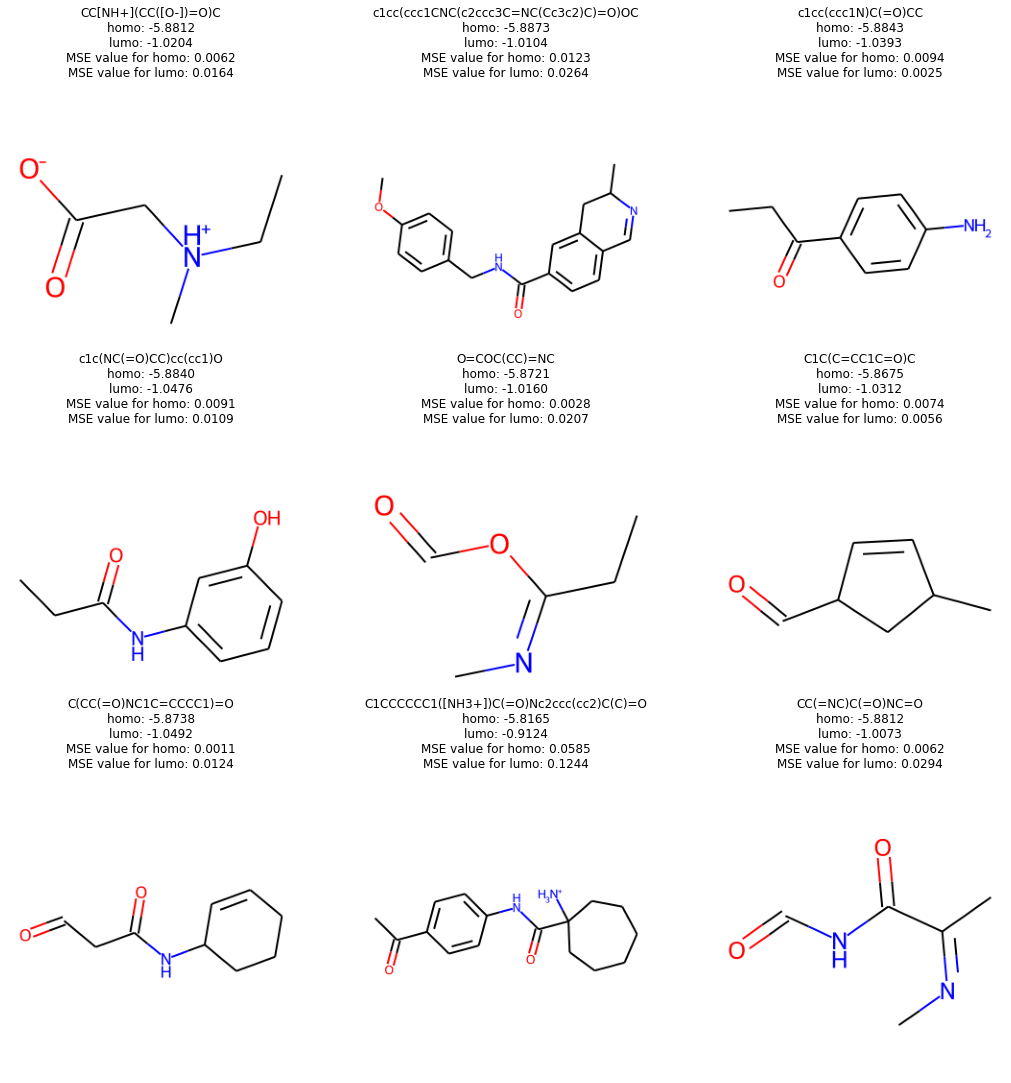

In [688]:
try:
    for i in range(50):
        resulting_properties = latent_space_descent_m(molecules, torch.tensor([-5.87494, -1.03675]), regressor, nn.MSELoss(reduction="none"), optimizer, 1)

        clear_output(wait=True)
        
        tree_vec, mol_vec = torch.split(molecules, molecules.size()[1]//2, 1)
        
        s = []
        for i, (tree, mol) in enumerate(zip(tree_vec, mol_vec)):
            _s = smiles(model.decode(tree[None, :],mol[None, :], False))
            _s.clean_stereo()
            _s.canonicalize()

            s.append(_s.__str__())
            
        D = dict()
        for keys, values in zip(["homo", "lumo"], np.split(resulting_properties, indices_or_sections = resulting_properties.shape[1], axis=1)):
            D.update({keys:values[:, 0].tolist()})

        show_molecules(s, D, [-5.87494, -1.03675])
        
except KeyboardInterrupt:
        clear_output(wait=True)
        
        s = []
        for i, (tree, mol) in enumerate(zip(tree_vec, mol_vec)):
            _s = smiles(model.decode(tree[None, :],mol[None, :], False))
            _s.clean_stereo()
            _s.canonicalize()

            s.append(_s.__str__())
            
        D = dict()
        for keys, values in zip(["homo", "lumo"], np.split(resulting_properties, indices_or_sections = resulting_properties.shape[1], axis=1)):
            D.update({keys:values[:, 0].tolist()})

        show_molecules(s, D, [-5.87494, -1.03675])

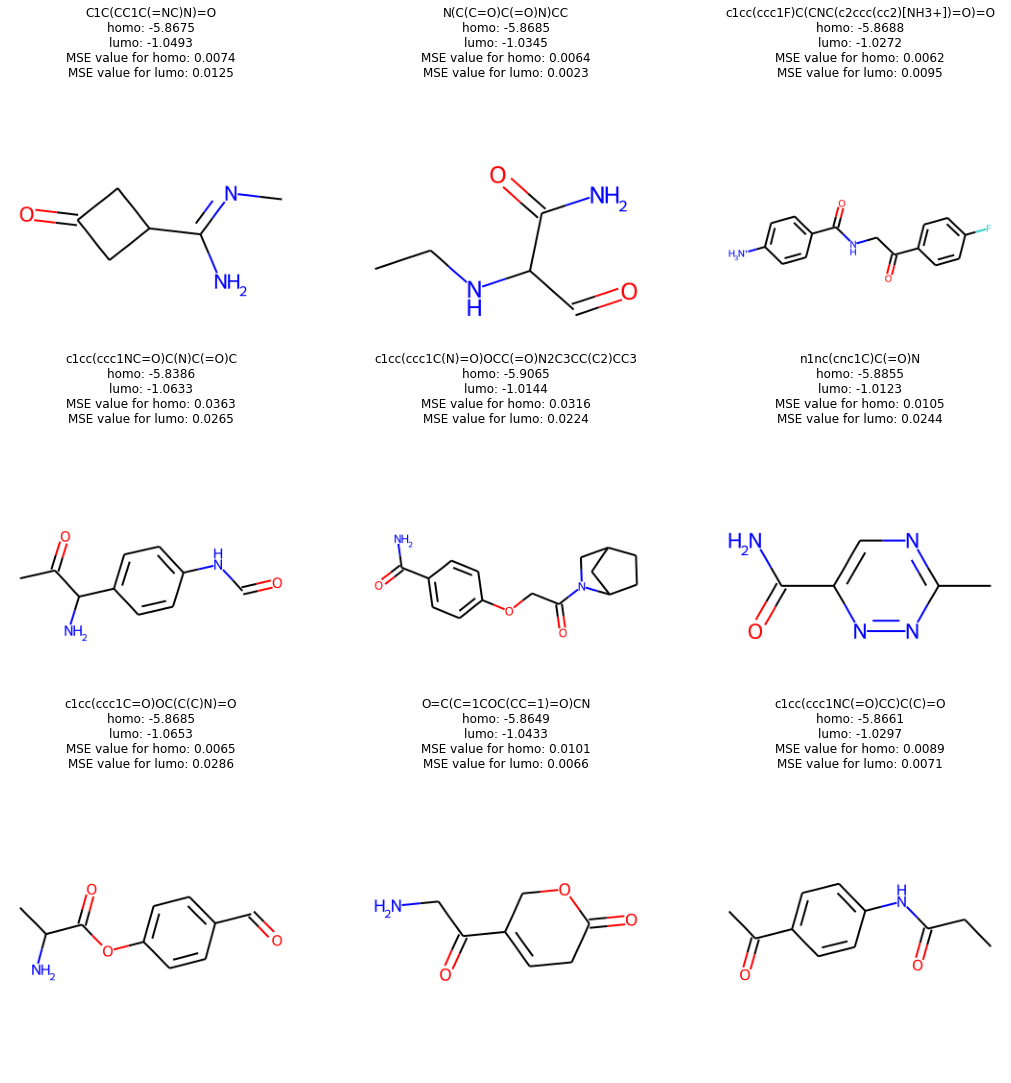

In [22]:
try:
    for i in range(50):
        resulting_properties = latent_space_descent_m(molecules, torch.tensor([-5.87494, -1.03675]), regressor, nn.MSELoss(reduction="none"), optimizer, 1)

        clear_output(wait=True)
        
        tree_vec, mol_vec = torch.split(molecules, molecules.size()[1]//2, 1)
        
        s = []
        for i, (tree, mol) in enumerate(zip(tree_vec, mol_vec)):
            _s = smiles(model.decode(tree[None, :],mol[None, :], False))
            _s.clean_stereo()
            _s.canonicalize()

            s.append(_s.__str__())
            
        D = dict()
        for keys, values in zip(["homo", "lumo"], np.split(resulting_properties, indices_or_sections = resulting_properties.shape[1], axis=1)):
            D.update({keys:values[:, 0].tolist()})

        show_molecules(s, D, [-5.87494, -1.03675])
        
except KeyboardInterrupt:
        clear_output(wait=True)
        
        s = []
        for i, (tree, mol) in enumerate(zip(tree_vec, mol_vec)):
            _s = smiles(model.decode(tree[None, :],mol[None, :], False))
            _s.clean_stereo()
            _s.canonicalize()

            s.append(_s.__str__())
            
        D = dict()
        for keys, values in zip(["homo", "lumo"], np.split(resulting_properties, indices_or_sections = resulting_properties.shape[1], axis=1)):
            D.update({keys:values[:, 0].tolist()})

        show_molecules(s, D, [-5.87494, -1.03675])

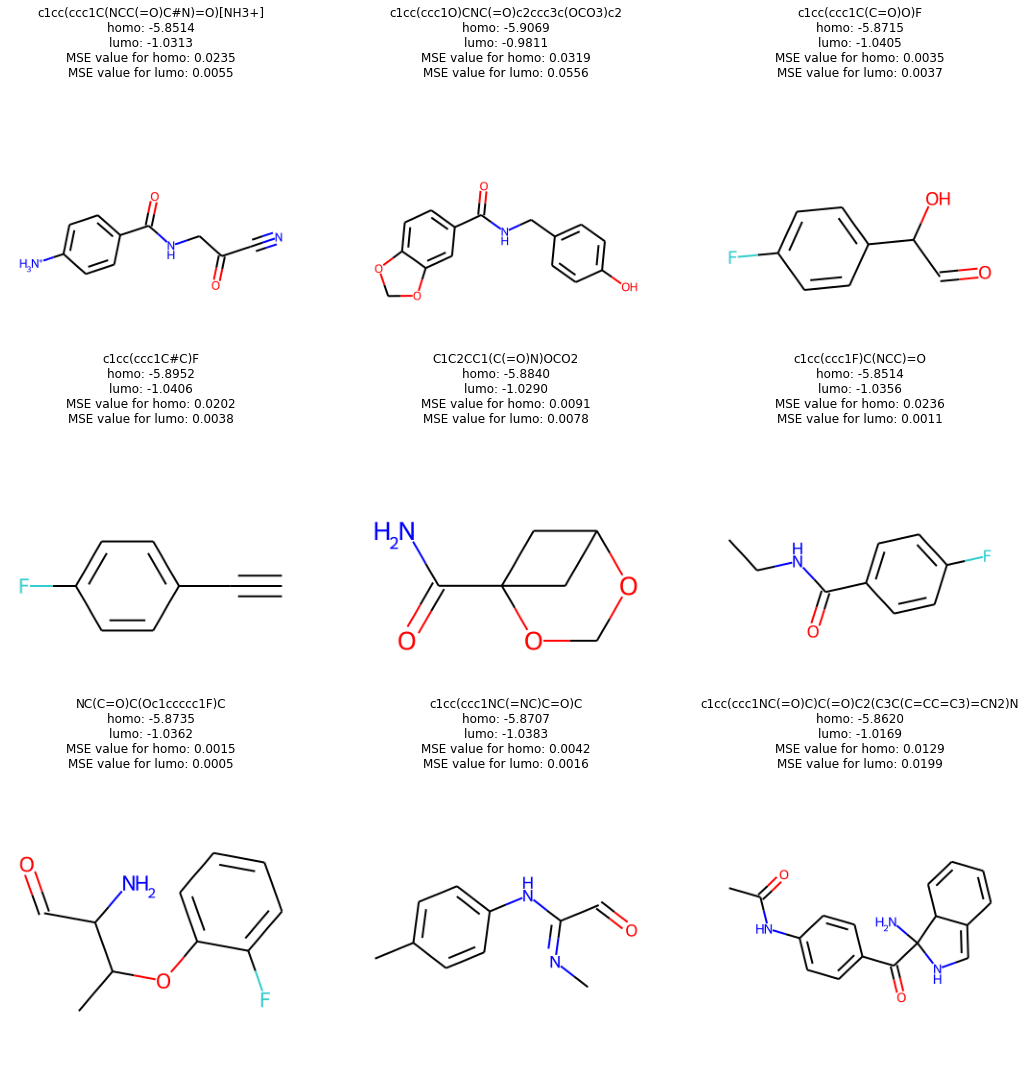

In [40]:
try:
    for i in range(50):
        resulting_properties = latent_space_descent_m(molecules, torch.tensor([-5.87494, -1.03675]), regressor, nn.MSELoss(reduction="none"), optimizer, 1)

        clear_output(wait=True)
        
        tree_vec, mol_vec = torch.split(molecules, molecules.size()[1]//2, 1)
        
        s = []
        for i, (tree, mol) in enumerate(zip(tree_vec, mol_vec)):
            _s = smiles(model.decode(tree[None, :],mol[None, :], False))
            _s.clean_stereo()
            _s.canonicalize()

            s.append(_s.__str__())
            
        D = dict()
        for keys, values in zip(["homo", "lumo"], np.split(resulting_properties, indices_or_sections = resulting_properties.shape[1], axis=1)):
            D.update({keys:values[:, 0].tolist()})

        show_molecules(s, D, [-5.87494, -1.03675])
        
except KeyboardInterrupt:
        clear_output(wait=True)
        
        s = []
        for i, (tree, mol) in enumerate(zip(tree_vec, mol_vec)):
            _s = smiles(model.decode(tree[None, :],mol[None, :], False))
            _s.clean_stereo()
            _s.canonicalize()

            s.append(_s.__str__())
            
        D = dict()
        for keys, values in zip(["homo", "lumo"], np.split(resulting_properties, indices_or_sections = resulting_properties.shape[1], axis=1)):
            D.update({keys:values[:, 0].tolist()})

        show_molecules(s, D, [-5.87494, -1.03675])

## Test and Validation decoding

### Decodings before and after the decomposition

In [229]:
predict_decode_predict(molecules, model, regressor)

,Latent0,Latent1,Molecule0,Molecule1,Difference
0,-6.027692,-0.684515,-6.066267,-0.858241,0.177957
1,-5.926826,-0.740193,-6.066267,-0.858241,0.182700
2,-6.054538,-0.579083,-6.066267,-0.858241,0.279404
3,-6.169144,-0.675226,-6.066267,-0.858241,0.209948
4,-5.993983,-0.770754,-6.066267,-0.858241,0.113485
5,-5.999152,-0.394591,-6.066267,-0.858241,0.468482
6,-5.979285,-0.503962,-6.066267,-0.858241,0.364801
7,-5.986681,-0.594569,-6.066267,-0.858241,0.275421
8,-5.981989,-0.553761,-6.066267,-0.858241,0.315928


### Searching for Val molecules

In [221]:
train_set = pd.read_csv('data/qdb9/prunned/qdb9/csv/train.csv')
test_set = pd.read_csv('data/qdb9/prunned/qdb9/csv/test.csv')
val_set = pd.read_csv('data/qdb9/prunned/qdb9/csv/val.csv')

In [296]:
train_smiles_set = set(train_set.smiles)
test_smiles_set = set(test_set.smiles)
val_smiles_set = set(val_set.smiles)

In [232]:
modelvae_path = 'vae_model/qdb9_zinc_prunned_256/model'
regressorvae_path = 'reg_model/qdb9_zinc_prunned_256_1024_homo_lumo_search/model_regression'

model = JTNNVAE(vocab, hidden_size, latent_size, depth, stereo=stereo)
model.load_state_dict(torch.load(modelvae_path))

regressor = nn.Sequential(
    nn.Linear(latent_size, 4096),
    nn.ReLU(),
    nn.Linear(4096, 4096),
    nn.ReLU(),
    nn.Linear(4096, 2),
)

regressor.load_state_dict(torch.load(regressorvae_path))

model = model.cuda()
regressor = regressor.cuda()

In [275]:
modelvae_path = 'reg_model/qdb9_zinc_prunned_256_lumo_best/model'
regressorvae_path = 'reg_model/qdb9_zinc_prunned_256_lumo_best/model_regression'


vocab = 
model_reg = JTNNVAE(vocab, hidden_size, latent_size, depth, stereo=stereo)

regressor_reg = nn.Sequential(
    nn.Linear(latent_size, 4096),
    nn.ReLU(),
    nn.Linear(4096, 4096),
    nn.ReLU(),
    nn.Linear(4096, 1),
)

regressor_reg.load_state_dict(torch.load(regressorvae_path))
model_reg.load_state_dict(torch.load(modelvae_path))

model_reg = model_reg.cuda()
regressor_reg = regressor_reg.cuda()

_ = model_reg.eval()
_ = regressor_reg.eval()

## Change sampling

In [497]:
tree_train_set = pd.DataFrame(columns = ["tree"])

size = math.ceil(train_set.shape[0]/batch_size)
pbar = tqdm(range(size))

for i in pbar:
    mol_tree = MolTree(smiles)
    mol_tree.recover()
    _,tree_vec,mol_vec = self.encode([mol_tree])

In [496]:
batch_size = 1024
X_train_set = []
model.eval()
size = math.ceil(train_set.shape[0]/batch_size)
pbar = tqdm(range(size))

for i in pbar:
    features = model.get_embeddings(list(train_set.smiles[batch_size*i: batch_size*(i+1)].apply(Mo)))

,smiles,homo,lumo,gap
0,CC1CC2OC(=N)NC12,-5.942664,1.534644,7.474587
1,CC1CN1C1COC1,-6.288231,2.089728,8.377959
2,CC(=O)OC1CC1C=O,-6.843315,-0.663924,6.179391
3,CCC1CC2(O)CC2O1,-6.372582,2.070681,8.440542
4,CNC12C(=O)OC1C2O,-6.478701,-0.209517,6.269184
...,...,...,...,...
101686,COCC1(C)COC1,-6.620193,2.092449,8.712642
101687,N#CC(=O)C1(C=O)CO1,-7.822875,-2.911470,4.908684
101688,CC(O)C1=NC2CC2O1,-6.843315,0.310194,7.153509
101689,C#CC1(CN2CC2)CC1,-5.983479,1.254381,7.240581


In [ ]:
lr_mol = 0.1
total = 0

train_overlap = 0
test_overlap = 0
val_overlap = 0

try:
    for j in range(test_set.shape[0]):
        ss, homo, lumo, gap = test_set.iloc[j]

        ss = smiles(ss)

        ss.clean_stereo()
        ss.canonicalize()
        ss = ss.__str__()

        target = [homo, lumo]

        idx = (((train_set[["homo", "lumo"]] - target)**2).sum(axis=1)).argmin()
        example = model.encode_latent_mean([train_set.loc[idx].smiles])

        molecules = init_latent_vector([100, 256], example)
        optimizer = optim.Adam([molecules], lr=lr_mol)

        resulting_properties = latent_space_descent_m(molecules, torch.FloatTensor(target), regressor, nn.MSELoss(reduction="none"), optimizer, 150)

        clear_output(wait=True)        
        tree_vec, mol_vec = torch.split(molecules, molecules.size()[1]//2, 1)

        s = set()

        for i, (tree, mol) in enumerate(zip(tree_vec, mol_vec)):
            _s = model.decode(tree[None, :],mol[None, :], False)
            if _s is not None:
                _s = smiles(model.decode(tree[None, :],mol[None, :], False))
                _s.clean_stereo()
                _s.canonicalize()

                s.add(_s.__str__())

        train_overlap += len(train_smiles_set.intersection(s))
        test_overlap += len(test_smiles_set.intersection(s))
        val_overlap += len(val_smiles_set.intersection(s))

        if ss in s:
            total+=1

        print("Iteration {}, Success rate: {}".format(j, total/(j+1)))
        print("Train overlap {}\nTest overlap {}\nValidation overlap {}\n".format(train_overlap/((j+1)*100),
                                                                                  test_overlap/((j+1)*100),
                                                                                  val_overlap/((j+1)*100)))
except KeyboardInterrupt:
    print("Iteration {}, Success rate: {}".format(j, total/(j+1)))
    print("Train overlap {}\nTest overlap {}\nValidation overlap {}\n".format(train_overlap/((j+1)*100),
                                                                              test_overlap/((j+1)*100),
                                                                              val_overlap/((j+1)*100)))
    

total_test = total
train_overlap_test = train_overlap
test_overlap_test = test_overlap
val_overlap_test = val_overlap

clear_output(wait=True) 
print("Iteration {}, Success rate: {}".format(test_set.shape[0], total_test/(test_set.shape[0])))
print("Train overlap {}\nTest overlap {}\nValidation overlap {}\n".format(train_overlap_test/((test_set.shape[0])*100),
                                                                          test_overlap_test/((test_set.shape[0])*100),
                                                                          val_overlap_test/((test_set.shape[0])*100)))

## Test

In [403]:
lr_mol = 0.1
total = 0

train_overlap = 0
test_overlap = 0
val_overlap = 0

try:
    for j in range(test_set.shape[0]):
        ss, homo, lumo, gap = test_set.iloc[j]

        ss = smiles(ss)

        ss.clean_stereo()
        ss.canonicalize()
        ss = ss.__str__()

        target = [homo, lumo]

        idx = (((train_set[["homo", "lumo"]] - target)**2).sum(axis=1)).argmin()
        example = model.encode_latent_mean([train_set.loc[idx].smiles])

        molecules = init_latent_vector([100, 256], example)
        optimizer = optim.Adam([molecules], lr=lr_mol)

        resulting_properties = latent_space_descent_m(molecules, torch.FloatTensor(target), regressor, nn.MSELoss(reduction="none"), optimizer, 150)

        clear_output(wait=True)        
        tree_vec, mol_vec = torch.split(molecules, molecules.size()[1]//2, 1)

        s = set()

        for i, (tree, mol) in enumerate(zip(tree_vec, mol_vec)):
            _s = model.decode(tree[None, :],mol[None, :], False)
            if _s is not None:
                _s = smiles(model.decode(tree[None, :],mol[None, :], False))
                _s.clean_stereo()
                _s.canonicalize()

                s.add(_s.__str__())

        train_overlap += len(train_smiles_set.intersection(s))
        test_overlap += len(test_smiles_set.intersection(s))
        val_overlap += len(val_smiles_set.intersection(s))

        if ss in s:
            total+=1

        print("Iteration {}, Success rate: {}".format(j, total/(j+1)))
        print("Train overlap {}\nTest overlap {}\nValidation overlap {}\n".format(train_overlap/((j+1)*100),
                                                                                  test_overlap/((j+1)*100),
                                                                                  val_overlap/((j+1)*100)))
except KeyboardInterrupt:
    print("Iteration {}, Success rate: {}".format(j, total/(j+1)))
    print("Train overlap {}\nTest overlap {}\nValidation overlap {}\n".format(train_overlap/((j+1)*100),
                                                                              test_overlap/((j+1)*100),
                                                                              val_overlap/((j+1)*100)))
    

total_test = total
train_overlap_test = train_overlap
test_overlap_test = test_overlap
val_overlap_test = val_overlap

clear_output(wait=True) 
print("Iteration {}, Success rate: {}".format(test_set.shape[0], total_test/(test_set.shape[0])))
print("Train overlap {}\nTest overlap {}\nValidation overlap {}\n".format(train_overlap_test/((test_set.shape[0])*100),
                                                                          test_overlap_test/((test_set.shape[0])*100),
                                                                          val_overlap_test/((test_set.shape[0])*100)))

Iteration 0, Success rate: 0.0022
Train overlap 0.002008
Test overlap 2.2e-05
Validation overlap 2e-05



## Val

In [ ]:
lr_mol = 0.1
total = 0

train_overlap = 0
test_overlap = 0
val_overlap = 0

try:
    for j in range(val_set.shape[0]):
        ss, homo, lumo, gap = val_set.iloc[j]

        ss = smiles(ss)

        ss.clean_stereo()
        ss.canonicalize()
        ss = ss.__str__()

        target = [homo, lumo]

        idx = (((train_set[["homo", "lumo"]] - target)**2).sum(axis=1)).argmin()
        example = model.encode_latent_mean([train_set.loc[idx].smiles])

        molecules = init_latent_vector([100, 256], example)
        optimizer = optim.Adam([molecules], lr=lr_mol)

        resulting_properties = latent_space_descent_m(molecules, torch.FloatTensor(target), regressor, nn.MSELoss(reduction="none"), optimizer, 150)

        clear_output(wait=True)        
        tree_vec, mol_vec = torch.split(molecules, molecules.size()[1]//2, 1)

        s = set()

        for i, (tree, mol) in enumerate(zip(tree_vec, mol_vec)):
            _s = model.decode(tree[None, :],mol[None, :], False)
            if _s is not None:
                _s = smiles(model.decode(tree[None, :],mol[None, :], False))
                _s.clean_stereo()
                _s.canonicalize()

                s.add(_s.__str__())

        train_overlap += len(train_smiles_set.intersection(s))
        test_overlap += len(test_smiles_set.intersection(s))
        val_overlap += len(val_smiles_set.intersection(s))

        if ss in s:
            total+=1

        print("Iteration {}, Success rate: {}".format(j, total/(j+1)))
        print("Train overlap {}\nTest overlap {}\nValidation overlap {}\n".format(train_overlap/((j+1)*100),
                                                                                  test_overlap/((j+1)*100),
                                                                                  val_overlap/((j+1)*100)))
except KeyboardInterrupt:
    print("Iteration {}, Success rate: {}".format(j, total/(j+1)))
    print("Train overlap {}\nTest overlap {}\nValidation overlap {}\n".format(train_overlap/((j+1)*100),
                                                                              test_overlap/((j+1)*100),
                                                                              val_overlap/((j+1)*100)))
    

total_val = total
train_overlap_val = train_overlap
test_overlap_val = test_overlap
val_overlap_val = val_overlap

clear_output(wait=True) 
print("Iteration {}, Success rate: {}".format(val_set.shape[0], total_val/(val_set.shape[0])))
print("Train overlap {}\nTest overlap {}\nValidation overlap {}\n".format(train_overlap_val/((val_set.shape[0])*100),
                                                                          test_overlap_val/((val_set.shape[0])*100),
                                                                          val_overlap_val/((val_set.shape[0])*100)))

Iteration 41, Success rate: 0.0
Train overlap 0.0033333333333333335
Test overlap 0.0
Validation overlap 0.0



## Train

In [ ]:
lr_mol = 0.1
total = 0

train_overlap = 0
test_overlap = 0
val_overlap = 0

try:
    for j in range(train_set.shape[0]):
        ss, homo, lumo, gap = train_set.iloc[j]

        ss = smiles(ss)

        ss.clean_stereo()
        ss.canonicalize()
        ss = ss.__str__()

        target = [homo, lumo]

        idx = (((train_set[["homo", "lumo"]] - target)**2).sum(axis=1)).argmin()
        example = model.encode_latent_mean([train_set.loc[idx].smiles])

        molecules = init_latent_vector([100, 256], example)
        optimizer = optim.Adam([molecules], lr=lr_mol)

        resulting_properties = latent_space_descent_m(molecules, torch.FloatTensor(target), regressor, nn.MSELoss(reduction="none"), optimizer, 150)

        clear_output(wait=True)        
        tree_vec, mol_vec = torch.split(molecules, molecules.size()[1]//2, 1)

        s = set()

        for i, (tree, mol) in enumerate(zip(tree_vec, mol_vec)):
            _s = model.decode(tree[None, :],mol[None, :], False)
            if _s is not None:
                _s = smiles(model.decode(tree[None, :],mol[None, :], False))
                _s.clean_stereo()
                _s.canonicalize()

                s.add(_s.__str__())

        train_overlap += len(train_smiles_set.intersection(s))
        test_overlap += len(test_smiles_set.intersection(s))
        val_overlap += len(val_smiles_set.intersection(s))

        if ss in s:
            total+=1

        print("Iteration {}, Success rate: {}".format(j, total/(j+1)))
        print("Train overlap {}\nTest overlap {}\nValidation overlap {}\n".format(train_overlap/((j+1)*100),
                                                                                  test_overlap/((j+1)*100),
                                                                                  val_overlap/((j+1)*100)))
except KeyboardInterrupt:
    total_train = total
    train_overlap_train = train_overlap
    test_overlap_train = test_overlap
    val_overlap_train = val_overlap
    print("Iteration {}, Success rate: {}".format(j, total/(j+1)))
    print("Train overlap {}\nTest overlap {}\nValidation overlap {}\n".format(train_overlap/((j+1)*100),
                                                                              test_overlap/((j+1)*100),
                                                                              val_overlap/((j+1)*100)))
    
    
total_train = total
train_overlap_train = train_overlap
test_overlap_train = test_overlap
val_overlap_train = val_overlap

## Predict new marians mols

In [532]:
vocab_path = "data/merged/vocab.txt"
vocab = [x.strip("\r\n ") for x in open(vocab_path)]
cset = set(vocab)
vocab = Vocab(vocab)

hidden_size = 612
latent_size = 256
depth = 3
stereo = True
batch_size = 8192
random_state = 42

modelvae_path = 'reg_model/merged_qdb9_256_612_homo/model'
regressorvae_path = 'reg_model/merged_qdb9_256_612_homo/model_regression'
model_reg = JTNNVAE(vocab, hidden_size, latent_size, depth, stereo=stereo)

regressor_reg = nn.Sequential(
    nn.Linear(latent_size, 4096),
    nn.ReLU(),
    nn.Linear(4096, 4096),
    nn.ReLU(),
    nn.Linear(4096, 1),
)

regressor_reg.load_state_dict(torch.load(regressorvae_path))
model_reg.load_state_dict(torch.load(modelvae_path))

model_reg = model_reg.cuda()
regressor_reg = regressor_reg.cuda()

_ = model_reg.eval()
_ = regressor_reg.eval()

In [533]:
new_real_data = pd.DataFrame({ 
    "smiles": [
        "c2ccc1cocc1c2",
        "c1ccc3c(c1)c2ccccc2c4cocc34",
        "c2cc3ccc4cccc5c1cocc1c(c2)c3c45",
        "c4ccc3cc2c(ccc1cocc12)cc3c4",
        "c1ccc3c(c1)ccc2cocc23",
        "c1ccc4c(c1)ccc3ccc2cocc2c34",
        "c1ccc2c(c1)ccc4c2ccc3cocc34",
        "c2cc3ccc4cc1cocc1c5ccc(c2)c3c45",
        "c1ccc4c(c1)ccc3cc2cocc2cc34",
        "c1ccc2c(c1)ccc5c2ccc4cc3cocc3cc45",
        "c3ccc2cc1cocc1cc2c3",
        "c4ccc3cc2cc1cocc1cc2cc3c4"], 
    "homo": [-5.25, -5.51, -5.54, -5.39, -5.39, -5.27, -5.22, -4.86, -4.91, -4.84, -4.78, -4.48],
    
}, index=[1, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14])

new_real_data.smiles = new_real_data.smiles.apply(clean)

In [556]:
from sklearn.metrics import r2_score
from scipy.stats import pearsonr

In [549]:
gt = []
pr = []
diff = []

for line in ["Molecule c1c2ccccc2co1, predicted value: -5.757090091705322, real value: -5.25, difference: 0.5070900917053223",
"Molecule c1c2c3ccccc3c4cocc4c2ccc1, predicted value: -5.630673885345459, real value: -5.51, difference: 0.1206738853454592",
"Molecule c12c3c4cccc3ccc1cccc2c5cocc45, predicted value: -5.522493839263916, real value: -5.54, difference: 0.01750616073608402",
"Molecule c1cc2cc3c(cc2cc1)ccc4c3coc4, predicted value: -4.917288303375244, real value: -5.39, difference: 0.47271169662475554",
"Molecule c12ccccc1ccc3c2coc3, predicted value: -5.673248767852783, real value: -5.39, difference: 0.2832487678527835",
"Molecule c1cccc2c1c3c(ccc4cocc34)cc2, predicted value: -5.381400108337402, real value: -5.27, difference: 0.11140010833740277",
"Molecule c1c2c(c3c(cccc3)c1)ccc4cocc24, predicted value: -6.051238059997559, real value: -5.22, difference: 0.8312380599975588",
"Molecule c12cocc1cc3ccc4cccc5ccc2c3c45, predicted value: -5.743382453918457, real value: -4.86, difference: 0.8833824539184567",
"Molecule c12ccc3c(cc4cocc4c3)c1cccc2, predicted value: -5.641488552093506, real value: -4.91, difference: 0.7314885520935057",
"Molecule c12c3ccc4c(cc5cocc5c4)c3ccc1cccc2, predicted value: -5.2047438621521, real value: -4.84, difference: 0.36474386215209975",
"Molecule c12c(cccc1)cc3cocc3c2, predicted value: -5.534309387207031, real value: -4.78, difference: 0.754309387207031",
"Molecule c12c(cc3c(cccc3)c1)cc4c(c2)coc4, predicted value: -6.212608337402344, real value: -4.48, difference: 1.7326083374023433"]:
    
    line = line.split(',')
    gt.append(float(line[2].split(":")[1]))
    pr.append(float(line[1].split(":")[1]))
    diff.append(abs(gt[-1] - pr[-1]))

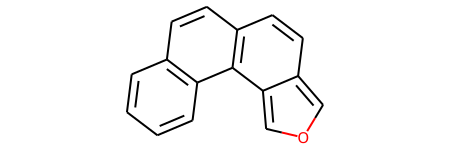

In [572]:
Chem.MolFromSmiles("c1cccc2c1c3c(ccc4cocc34)cc2")

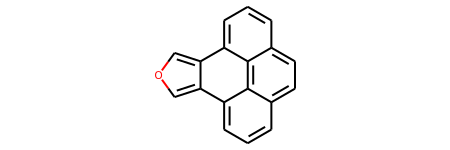

In [570]:
Chem.MolFromSmiles("c12c3c4cccc3ccc1cccc2c5cocc45")

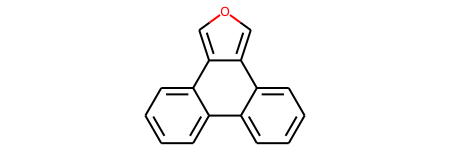

In [571]:
Chem.MolFromSmiles("c1c2c3ccccc3c4cocc4c2ccc1")

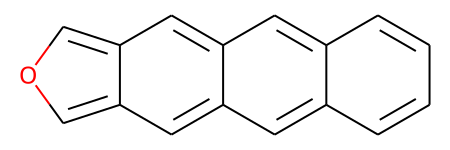

In [569]:
Chem.MolFromSmiles("c12c(cc3c(cccc3)c1)cc4c(c2)coc4")

**Mol** c12c3ccc4c(cc5cocc5c4)c3ccc1cccc2, predicted value: -5.2047438621521, real value: -4.84, difference: 0.36474386215209975 !!

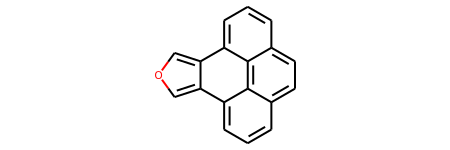

In [1165]:
Chem.MolFromSmiles("c12c3c4cccc3ccc1cccc2c5cocc45")

In [534]:
for i in range(12):
    try:
        coeff = get_coefficient([list(new_real_data.smiles)[i]], model_reg, regressor_reg).item()
        print("Molecule {}, predicted value: {}, real value: {}, difference: {}". format(
            list(new_real_data.smiles)[i],
            coeff, 
            new_real_data.homo.iloc[i], 
            abs(coeff - float(new_real_data.homo.iloc[i]))))
    except KeyError as e:
        print("Molecule {} have problem with structure {}".format(list(new_real_data.smiles)[i], e))

Molecule c1c2ccccc2co1, predicted value: -5.757090091705322, real value: -5.25, difference: 0.5070900917053223
Molecule c1c2c3ccccc3c4cocc4c2ccc1, predicted value: -5.630673885345459, real value: -5.51, difference: 0.1206738853454592
Molecule c12c3c4cccc3ccc1cccc2c5cocc45, predicted value: -5.522493839263916, real value: -5.54, difference: 0.01750616073608402
Molecule c1cc2cc3c(cc2cc1)ccc4c3coc4, predicted value: -4.917288303375244, real value: -5.39, difference: 0.47271169662475554
Molecule c12ccccc1ccc3c2coc3, predicted value: -5.673248767852783, real value: -5.39, difference: 0.2832487678527835
Molecule c1cccc2c1c3c(ccc4cocc34)cc2, predicted value: -5.381400108337402, real value: -5.27, difference: 0.11140010833740277
Molecule c1c2c(c3c(cccc3)c1)ccc4cocc24, predicted value: -6.051238059997559, real value: -5.22, difference: 0.8312380599975588
Molecule c12cocc1cc3ccc4cccc5ccc2c3c45, predicted value: -5.743382453918457, real value: -4.86, difference: 0.8833824539184567
Molecule c12ccc

In [535]:
new_real_data = pd.DataFrame({ 
    "smiles": [
        "O=c1nnc(=O)n1c2cc(C(F)(F)F)cc(C(F)(F)F)c2",
        "Cn1c(=O)nnc1=O",
        "O=c1nnc(=O)s1",
        "O=c1nnc(=O)[nH]1",
        "O=c1nnc(=O)n1c2ccccc2",
        "CC1(C)C(=O)/N=N\C1=O",
        "O=c1nnc(=O)n1c2ccc(N(=O)=O)cc2",
        "O=c1ccc(=O)nn1"], 
    "homo": [-11.2, -10.8, -10.9, -10.8, -10.4, -9.9, -10.9, -9.9],
    "lumo": [-9.7, -9.7, -9.5, -9.3, -8.9, -8.8, -9.5, -8.7]
    
})

new_real_data.smiles = new_real_data.smiles.apply(clean)

In [537]:
print("homo")
for i in range(new_real_data.shape[0]):
    try:
        coeff = get_coefficient([list(new_real_data.smiles)[i]], model_reg, regressor_reg).item()
        print("Molecule {}, predicted value: {}, real value: {}, difference: {}". format(
            list(new_real_data.smiles)[i],
            coeff, 
            new_real_data.homo.iloc[i], 
            abs(coeff - float(new_real_data.homo.iloc[i]))))
    except KeyError as e:
        print("Molecule {} have problem with structure {}".format(list(new_real_data.smiles)[i], e))

homo
Molecule FC(F)(F)c1cc(cc(C(F)(F)F)c1)N2C(=O)N=NC2=O, predicted value: -8.04102611541748, real value: -11.2, difference: 3.158973884582519
Molecule C1(=O)N=NC(=O)N1C, predicted value: -8.0481538772583, real value: -10.8, difference: 2.7518461227417
Molecule N1=NC(=O)SC1=O, predicted value: -8.230670928955078, real value: -10.9, difference: 2.6693290710449222
Molecule N1=NC(=O)NC1=O, predicted value: -7.996319770812988, real value: -10.8, difference: 2.8036802291870124
Molecule O=C1N=NC(=O)N1c2ccccc2, predicted value: -7.322929382324219, real value: -10.4, difference: 3.0770706176757816
Molecule CC1(C)C(N=NC1=O)=O, predicted value: -6.565465927124023, real value: -9.9, difference: 3.334534072875977
Molecule c1cc(ccc1[N+](=O)[O-])N2C(N=NC2=O)=O, predicted value: -9.089550971984863, real value: -10.9, difference: 1.810449028015137
Molecule C1=CC(N=NC1=O)=O have problem with structure 'C1=CCN=NC1'


In [8]:
vocab_path = "data/merged/vocab.txt"
vocab = [x.strip("\r\n ") for x in open(vocab_path)]
cset = set(vocab)
vocab = Vocab(vocab)

hidden_size = 612
latent_size = 256
depth = 3
stereo = True
batch_size = 8192
random_state = 42

modelvae_path = 'reg_model/merged_qdb9_256_612_lumo/model'
regressorvae_path = 'reg_model/merged_qdb9_256_612_lumo/model_regression'
model_reg = JTNNVAE(vocab, hidden_size, latent_size, depth, stereo=stereo)

regressor_reg = nn.Sequential(
    nn.Linear(latent_size, 4096),
    nn.ReLU(),
    nn.Linear(4096, 4096),
    nn.ReLU(),
    nn.Linear(4096, 1),
)

regressor_reg.load_state_dict(torch.load(regressorvae_path))
model_reg.load_state_dict(torch.load(modelvae_path))

model_reg = model_reg.cuda()
regressor_reg = regressor_reg.cuda()

_ = model_reg.eval()
_ = regressor_reg.eval()

In [540]:
print("lumo")
for i in range(new_real_data.shape[0]):
    try:
        coeff = get_coefficient([list(new_real_data.smiles)[i]], model_reg, regressor_reg).item()
        print("Molecule {}, predicted value: {}, real value: {}, difference: {}". format(
            list(new_real_data.smiles)[i],
            coeff, 
            new_real_data.homo.iloc[i], 
            abs(coeff - float(new_real_data.homo.iloc[i]))))
    except KeyError as e:
        print("Molecule {} have problem with structure {}".format(list(new_real_data.smiles)[i], e))

lumo
Molecule FC(F)(F)c1cc(cc(C(F)(F)F)c1)N2C(=O)N=NC2=O, predicted value: -2.9594318866729736, real value: -11.2, difference: 8.240568113327026
Molecule C1(=O)N=NC(=O)N1C, predicted value: -2.801607608795166, real value: -10.8, difference: 7.998392391204835
Molecule N1=NC(=O)SC1=O, predicted value: -2.6239840984344482, real value: -10.9, difference: 8.276015901565552
Molecule N1=NC(=O)NC1=O, predicted value: -3.361778497695923, real value: -10.8, difference: 7.438221502304078
Molecule O=C1N=NC(=O)N1c2ccccc2, predicted value: -2.5696637630462646, real value: -10.4, difference: 7.830336236953736
Molecule CC1(C)C(N=NC1=O)=O, predicted value: -2.1207275390625, real value: -9.9, difference: 7.7792724609375
Molecule c1cc(ccc1[N+](=O)[O-])N2C(N=NC2=O)=O, predicted value: -4.683241367340088, real value: -10.9, difference: 6.2167586326599125
Molecule C1=CC(N=NC1=O)=O have problem with structure 'C1=CCN=NC1'


## Double optimisation

In [333]:
def double_descent(variables,
                   target,
                   search_model,
                   search_regression,
                   regression_model,
                   regression_regressor,
                   loss,
                   lr,
                   n_steps = 1,
                   n_iter = 1,
                   verbose=True):
    
    search_model.eval()
    search_regression.eval()
    regression_model.eval()
    regression_regressor.eval()
    try:
        
        if verbose:
            pbar = tqdm(range(n_iter))
            
        else:
            pbar = range(n_iter)
            
        for j in pbar:
            tree_vec, mol_vec = torch.split(variables, variables.size()[1]//2, 1)
            s = []

            for i, (tree, mol) in enumerate(zip(tree_vec, mol_vec)):
                s_string = search_model.decode(tree[None, :],mol[None, :], False)

                if s_string is not None:
                    _s = smiles(search_model.decode(tree[None, :],mol[None, :], False))
                    _s.clean_stereo()
                    _s.canonicalize()
                    s.append(_s.__str__())

            s = list(filter(lambda x: Chem.MolFromSmiles(x) is not None, set(s)))
            coeffs = regression_regressor(regression_model.encode_latent_mean(s))
            idxes = torch.abs(coeffs - target).argsort(dim=0).flatten()
            variables = variables[idxes[:10]].repeat((10, 1))
            variables = (variables.detach() + torch.rand([variables.shape[0], 256], device="cuda"))
            variables.requires_grad = True 
            optimizer = optim.Adam([variables], lr=lr)

            regressor.train()
            props = (torch.ones(variables.size()[0], 1, device="cuda")*target).cuda()
            for i in range(n_steps):
                search_regression.zero_grad()
                optimizer.zero_grad()

                prediction = search_regressor(variables)
                wloss = loss(prediction, props)
                wloss.backward()
                optimizer.step()
        return variables
    
    except:
        return variables

In [253]:
vocab_path = "data/merged/vocab.txt"
vocab = [x.strip("\r\n ") for x in open(vocab_path)]
cset = set(vocab)
vocab = Vocab(vocab)

hidden_size = 612
latent_size = 256
depth = 3
stereo = True

batch_size = 8192
random_state = 42

modelvae_path = 'vae_model/merged_qdb9_256_612/model'
regressorvae_path = 'reg_model/merged_search_qdb9_256_612_lumo/model_regression'

search_model = JTNNVAE(vocab, hidden_size, latent_size, depth, stereo=stereo)
search_model.load_state_dict(torch.load(modelvae_path))

search_regressor = nn.Sequential(
    nn.Linear(latent_size, 4096),
    nn.ReLU(),
    nn.Linear(4096, 4096),
    nn.ReLU(),
    nn.Linear(4096, 1),
)

search_regressor.load_state_dict(torch.load(regressorvae_path))

search_model = search_model.cuda()
search_regressor = search_regressor.cuda()

In [254]:
modelvae_path = 'reg_model/merged_qdb9_256_612_lumo/model'
regressorvae_path = 'reg_model/merged_qdb9_256_612_lumo/model_regression'

regression_model = JTNNVAE(vocab, hidden_size, latent_size, depth, stereo=stereo)
regression_model.load_state_dict(torch.load(modelvae_path))

regression_regressor = nn.Sequential(
    nn.Linear(latent_size, 4096),
    nn.ReLU(),
    nn.Linear(4096, 4096),
    nn.ReLU(),
    nn.Linear(4096, 1),
)



regression_regressor.load_state_dict(torch.load(regressorvae_path))

regression_model = regression_model.cuda()
regression_regressor = regression_regressor.cuda()

lr_mol = 0.1
target = [0.427197]
data = pd.read_csv("data/qdb9/prunned/qdb9/csv/qdb9_prunned.csv")
idx = (((data[["lumo"]] - target)**2).sum(axis=1)).argmin()
example = regression_model.encode_latent_mean([data.loc[idx].smiles])

molecules = init_latent_vector([100, 256], example)

target = torch.tensor(target, device="cuda")

In [255]:
test_set = pd.read_csv("data/merged/csv/test_reg.csv", index_col=0)
train_set = pd.read_csv("data/merged/csv/train_reg.csv", index_col=0)
val_set = pd.read_csv("data/merged/csv/val_reg.csv", index_col=0)

train_smiles_set = set(train_set.smiles)
test_smiles_set = set(test_set.smiles)
val_smiles_set = set(val_set.smiles)
lr_mol = 0.1
total = 0

train_overlap = 0
test_overlap = 0
val_overlap = 0

In [ ]:
try:
    for k in range(test_set.shape[0]):
        ss, homo, lumo, gap = test_set[["smiles", "homo", "lumo", "gap"]].iloc[k]

        ss = smiles(ss)

        ss.clean_stereo()
        ss.canonicalize()
        ss = ss.__str__()

        target = [lumo]

        idx = (((train_set[["lumo"]] - target)**2).sum(axis=1)).argmin()
        example = search_model.encode_latent_mean([train_set.iloc[idx].smiles])

        molecules = init_latent_vector([100, 256], example)
        
        target = torch.FloatTensor(target)
        target = target.to(torch.device("cuda"))

        molecules = double_descent(molecules,
                                   target,
                                   search_model,
                                   search_regressor,
                                   regression_model,
                                   regression_regressor,
                                   nn.MSELoss(reduction="mean"), lr_mol, 50, 10)

        clear_output(wait=True)        
        tree_vec, mol_vec = torch.split(molecules, molecules.size()[1]//2, 1)

        s = set()

        for i, (tree, mol) in enumerate(zip(tree_vec, mol_vec)):
            _s = model.decode(tree[None, :],mol[None, :], False)
            if _s is not None:
                _s = smiles(model.decode(tree[None, :],mol[None, :], False))
                _s.clean_stereo()
                _s.canonicalize()

                s.add(_s.__str__())

        train_overlap += len(train_smiles_set.intersection(s))
        test_overlap += len(test_smiles_set.intersection(s))
        val_overlap += len(val_smiles_set.intersection(s))

        if ss in s:
            total+=1

        print("Iteration {}, Success rate: {}".format(k, total/(k+1)))
        print("Train overlap {}\nTest overlap {}\nValidation overlap {}\n".format(train_overlap/((k+1)*100),
                                                                                  test_overlap/((k+1)*100),
                                                                                  val_overlap/((k+1)*100)))
except KeyboardInterrupt:
    print("Iteration {}, Success rate: {}".format(k, total/(k+1)))
    print("Train overlap {}\nTest overlap {}\nValidation overlap {}\n".format(train_overlap/((k+1)*100),
                                                                              test_overlap/((k+1)*100),
                                                                              val_overlap/((k+1)*100)))
    

merged_total_test = total
merged_train_overlap_test = train_overlap
merged_test_overlap_test = test_overlap
merged_val_overlap_test = val_overlap
 
print("Iteration {}, Success rate: {}".format(test_set.shape[0], merged_total_test/(test_set.shape[0])))
print("Train overlap {}\nTest overlap {}\nValidation overlap {}\n".format(merged_train_overlap_test/((test_set.shape[0])*100),
                                                                          merged_test_overlap_test/((test_set.shape[0])*100),
                                                                          merged_val_overlap_test/((test_set.shape[0])*100)))

Iteration 49, Success rate: 0.0
Train overlap 0.0008
Test overlap 0.0
Validation overlap 0.0



 50% 5/10 [01:44<01:50, 22.10s/it]

In [260]:
print("Iteration {}, Success rate: {}".format(test_set.shape[0], merged_total_test/(test_set.shape[0])))
print("Train overlap {}\nTest overlap {}\nValidation overlap {}\n".format(merged_train_overlap_test/((test_set.shape[0])*100),
                                                                          merged_test_overlap_test/((test_set.shape[0])*100),
                                                                          merged_val_overlap_test/((test_set.shape[0])*100)))

Iteration 5000, Success rate: 0.0
Train overlap 7.8e-05
Test overlap 0.0
Validation overlap 0.0



In [ ]:
train_overlap = 0
test_overlap = 0
val_overlap = 0
total = 0


try:
    for k in range(val_set.shape[0]):
        ss, homo, lumo, gap = val_set[["smiles", "homo", "lumo", "gap"]].iloc[k]

        ss = smiles(ss)

        ss.clean_stereo()
        ss.canonicalize()
        ss = ss.__str__()

        target = [lumo]

        idx = (((train_set[["lumo"]] - target)**2).sum(axis=1)).argmin()
        example = search_model.encode_latent_mean([train_set.iloc[idx].smiles])

        molecules = init_latent_vector([100, 256], example)
        
        target = torch.FloatTensor(target)
        target = target.to(torch.device("cuda"))

        molecules = double_descent(molecules,
                                   target,
                                   search_model,
                                   search_regressor,
                                   regression_model,
                                   regression_regressor,
                                   nn.MSELoss(reduction="mean"), lr_mol, 50, 10)

        clear_output(wait=True)        
        tree_vec, mol_vec = torch.split(molecules, molecules.size()[1]//2, 1)

        s = set()

        for i, (tree, mol) in enumerate(zip(tree_vec, mol_vec)):
            _s = model.decode(tree[None, :],mol[None, :], False)
            if _s is not None:
                _s = smiles(model.decode(tree[None, :],mol[None, :], False))
                _s.clean_stereo()
                _s.canonicalize()

                s.add(_s.__str__())

        train_overlap += len(train_smiles_set.intersection(s))
        test_overlap += len(test_smiles_set.intersection(s))
        val_overlap += len(val_smiles_set.intersection(s))

        if ss in s:
            total+=1

        print("Iteration {}, Success rate: {}".format(k, total/(k+1)))
        print("Train overlap {}\nTest overlap {}\nValidation overlap {}\n".format(train_overlap/((k+1)*100),
                                                                                  test_overlap/((k+1)*100),
                                                                                  val_overlap/((k+1)*100)))
except KeyboardInterrupt:
    print("Iteration {}, Success rate: {}".format(k, total/(k+1)))
    print("Train overlap {}\nTest overlap {}\nValidation overlap {}\n".format(train_overlap/((k+1)*100),
                                                                              test_overlap/((k+1)*100),
                                                                              val_overlap/((k+1)*100)))
    

merged_total_val = total
merged_train_overlap_val = train_overlap
merged_test_overlap_val = test_overlap
merged_val_overlap_val = val_overlap
 
print("Iteration {}, Success rate: {}".format(val_set.shape[0], merged_total_val/(val_set.shape[0])))
print("Train overlap {}\nTest overlap {}\nValidation overlap {}\n".format(merged_train_overlap_val/((val_set.shape[0])*100),
                                                                          merged_test_overlap_val/((val_set.shape[0])*100),
                                                                          merged_val_overlap_val/((val_set.shape[0])*100)))

In [ ]:
vocab_path = "data/qdb9/prunned/vocab.txt"
vocab = [x.strip("\r\n ") for x in open(vocab_path)]
cset = set(vocab)
vocab = Vocab(vocab)

batch_size = 128
hidden_size = 450
latent_size = 256
depth = 3
stereo = True

batch_size = 8192
random_state = 42

modelvae_path = 'vae_model/qdb9_zinc_prunned_256/model'
regressorvae_path = 'reg_model/qdb9_zinc_prunned_256_4096_lumo_search/model_regression'

search_model = JTNNVAE(vocab, hidden_size, latent_size, depth, stereo=stereo)
search_model.load_state_dict(torch.load(modelvae_path))

search_regressor = nn.Sequential(
    nn.Linear(latent_size, 4096),
    nn.ReLU(),
    nn.Linear(4096, 4096),
    nn.ReLU(),
    nn.Linear(4096, 1),
)

search_regressor.load_state_dict(torch.load(regressorvae_path))

search_model = search_model.cuda()
search_regressor = search_regressor.cuda()

modelvae_path = 'reg_model/qdb9_prunned_256_lumo/model'
regressorvae_path = 'reg_model/qdb9_prunned_256_lumo/model_regression'

regression_model = JTNNVAE(vocab, hidden_size, latent_size, depth, stereo=stereo)
regression_model.load_state_dict(torch.load(modelvae_path))

regression_regressor = nn.Sequential(
    nn.Linear(latent_size, 4096),
    nn.ReLU(),
    nn.Linear(4096, 4096),
    nn.ReLU(),
    nn.Linear(4096, 1),
)



regression_regressor.load_state_dict(torch.load(regressorvae_path))

regression_model = regression_model.cuda()
regression_regressor = regression_regressor.cuda()

lr_mol = 0.1
target = [0.427197]
data = pd.read_csv("data/qdb9/prunned/qdb9/csv/qdb9_prunned.csv")
idx = (((data[["lumo"]] - target)**2).sum(axis=1)).argmin()
example = regression_model.encode_latent_mean([data.loc[idx].smiles])

molecules = init_latent_vector([100, 256], example)

target = torch.tensor(target, device="cuda")

In [ ]:
test_set = pd.read_csv("data/qdb9/prunned/qdb9/csv/test.csv", index_col=0)
train_set = pd.read_csv("data/qdb9/prunned/qdb9/csv/train.csv", index_col=0)
val_set = pd.read_csv("data/qdb9/prunned/qdb9/csv/val.csv", index_col=0)

train_smiles_set = set(train_set.smiles)
test_smiles_set = set(test_set.smiles)
val_smiles_set = set(val_set.smiles)
lr_mol = 0.1
total = 0

train_overlap = 0
test_overlap = 0
val_overlap = 0
total = 0

In [ ]:
try:
    for k in range(val_set.shape[0]):
        ss, homo, lumo, gap = val_set[["smiles", "homo", "lumo", "gap"]].iloc[k]

        ss = smiles(ss)

        ss.clean_stereo()
        ss.canonicalize()
        ss = ss.__str__()

        target = [lumo]

        idx = (((train_set[["lumo"]] - target)**2).sum(axis=1)).argmin()
        example = search_model.encode_latent_mean([train_set.iloc[idx].smiles])

        molecules = init_latent_vector([100, 256], example)
        
        target = torch.FloatTensor(target)
        target = target.to(torch.device("cuda"))

        molecules = double_descent(molecules,
                                   target,
                                   search_model,
                                   search_regressor,
                                   regression_model,
                                   regression_regressor,
                                   nn.MSELoss(reduction="mean"), lr_mol, 50, 10)

        clear_output(wait=True)        
        tree_vec, mol_vec = torch.split(molecules, molecules.size()[1]//2, 1)

        s = set()

        for i, (tree, mol) in enumerate(zip(tree_vec, mol_vec)):
            _s = model.decode(tree[None, :],mol[None, :], False)
            if _s is not None:
                _s = smiles(model.decode(tree[None, :],mol[None, :], False))
                _s.clean_stereo()
                _s.canonicalize()

                s.add(_s.__str__())

        train_overlap += len(train_smiles_set.intersection(s))
        test_overlap += len(test_smiles_set.intersection(s))
        val_overlap += len(val_smiles_set.intersection(s))

        if ss in s:
            total+=1

        print("Iteration {}, Success rate: {}".format(k, total/(k+1)))
        print("Train overlap {}\nTest overlap {}\nValidation overlap {}\n".format(train_overlap/((k+1)*100),
                                                                                  test_overlap/((k+1)*100),
                                                                                  val_overlap/((k+1)*100)))
except KeyboardInterrupt:
    print("Iteration {}, Success rate: {}".format(k, total/(k+1)))
    print("Train overlap {}\nTest overlap {}\nValidation overlap {}\n".format(train_overlap/((k+1)*100),
                                                                              test_overlap/((k+1)*100),
                                                                              val_overlap/((k+1)*100)))
    

merged_total_small_val = total
merged_train_overlap_small_val = train_overlap
merged_test_overlap_small_val = test_overlap
merged_val_overlap_small_val = val_overlap
 
print("Iteration {}, Success rate: {}".format(val_set.shape[0], merged_total_small_val/(val_set.shape[0])))
print("Train overlap {}\nTest overlap {}\nValidation overlap {}\n".format(merged_train_overlap_small_val/((val_set.shape[0])*100),
                                                                          merged_test_overlap_small_val/((val_set.shape[0])*100),
                                                                          merged_val_overlap_small_val/((val_set.shape[0])*100)))

## Double optimisation

In [405]:
vocab_path = "data/merged/vocab.txt"
vocab = [x.strip("\r\n ") for x in open(vocab_path)]
cset = set(vocab)
vocab = Vocab(vocab)

hidden_size = 612
latent_size = 256
depth = 3
stereo = True

batch_size = 8192
random_state = 42

modelvae_path = 'vae_model/merged_qdb9_256_612/model'
regressorvae_path = 'reg_model/merged_search_qdb9_256_612_lumo/model_regression'

search_model = JTNNVAE(vocab, hidden_size, latent_size, depth, stereo=stereo)
search_model.load_state_dict(torch.load(modelvae_path))

search_regressor = nn.Sequential(
    nn.Linear(latent_size, 4096),
    nn.ReLU(),
    nn.Linear(4096, 4096),
    nn.ReLU(),
    nn.Linear(4096, 1),
)

search_regressor.load_state_dict(torch.load(regressorvae_path))

search_model = search_model.cuda()
search_regressor = search_regressor.cuda()

modelvae_path = 'reg_model/merged_qdb9_256_612_homo/model'
regressorvae_path = 'reg_model/merged_qdb9_256_612_homo/model_regression'

regression_model = JTNNVAE(vocab, hidden_size, latent_size, depth, stereo=stereo)
regression_model.load_state_dict(torch.load(modelvae_path))

regression_regressor = nn.Sequential(
    nn.Linear(latent_size, 4096),
    nn.ReLU(),
    nn.Linear(4096, 4096),
    nn.ReLU(),
    nn.Linear(4096, 1),
)



regression_regressor.load_state_dict(torch.load(regressorvae_path))

regression_model = regression_model.cuda()
regression_regressor = regression_regressor.cuda()

In [406]:
s = "c12c3ccc4c(cc5cocc5c4)c3ccc1cccc2"
homo_s_p = -5.2047438621521
homo_s = -4.84
diff_s = 0.36474386215209975
scale = 27.21

In [ ]:
search_model.eval()
search_regression.eval()
regression_model.eval()
regression_regressor.eval()
try:

    if verbose:
        pbar = tqdm(range(n_iter))

    else:
        pbar = range(n_iter)

    for j in pbar:
        tree_vec, mol_vec = torch.split(variables, variables.size()[1]//2, 1)
        s = []

        for i, (tree, mol) in enumerate(zip(tree_vec, mol_vec)):
            s_string = search_model.decode(tree[None, :],mol[None, :], False)

            if s_string is not None:
                _s = smiles(search_model.decode(tree[None, :],mol[None, :], False))
                _s.clean_stereo()
                _s.canonicalize()
                s.append(_s.__str__())

        s = list(filter(lambda x: Chem.MolFromSmiles(x) is not None, set(s)))
        coeffs = regression_regressor(regression_model.encode_latent_mean(s))
        idxes = torch.abs(coeffs - target).argsort(dim=0).flatten()
        variables = variables[idxes[:10]].repeat((10, 1))
        variables = (variables.detach() + torch.rand([variables.shape[0], 256], device="cuda"))
        variables.requires_grad = True 
        optimizer = optim.Adam([variables], lr=lr)

        regressor.train()
        props = (torch.ones(variables.size()[0], 1, device="cuda")*target).cuda()
        for i in range(n_steps):
            search_regression.zero_grad()
            optimizer.zero_grad()

            prediction = search_regressor(variables)
            wloss = loss(prediction, props)
            wloss.backward()
            optimizer.step()
    return variables

In [997]:
search_model.eval()
search_regressor.eval()
regression_model.eval()
regression_regressor.eval()

idx = ((train_set.homo - [homo_s])**2).argmin()
example = search_model.encode_latent_mean([train_set.iloc[idx].smiles])
molecules = init_latent_vector([10, 256], example)
target = torch.tensor([homo_s], device="cuda")
loss = nn.L1Loss(reduction="sum")

In [998]:
best_coeff = torch.tensor(1000)

for i in range(20):
    tree_vec, mol_vec = torch.split(molecules, molecules.size()[1]//2, 1)
    s = []
    for i, (tree, mol) in enumerate(zip(tree_vec, mol_vec)):
        s_string = search_model.decode(tree[None, :],mol[None, :], False)

        if s_string is not None:
            _s = smiles(s_string)
            _s.clean_stereo()
            _s.canonicalize()
            s.append(_s.__str__())

    s = list(filter(lambda x: Chem.MolFromSmiles(x) is not None, set(s)))

    coeffs = regression_regressor(regression_model.encode_latent_mean(s))
    idxes = torch.abs(coeffs - target).argsort(dim=0).flatten()
    print(coeffs[idxes[0]].item(), target.item(), best_coeff.item())
    if abs(target - coeffs[idxes[0]]) < best_coeff:
        best_coeff = abs(target - coeffs[idxes[0]]) 
        candidate = molecules[idxes[0], :].detach()[None]
        
    check = candidate.clone()
    molecules = (candidate.repeat((20, 1)) + torch.rand([20, 256], device="cuda")*3)
    molecules.requires_grad = True 
    optimizer = optim.Adam([molecules], lr=0.1)

    props = (torch.ones(molecules.size()[0], 1, device="cuda")*target).cuda()
    
    for i in range(100):
        search_regressor.zero_grad()
        optimizer.zero_grad()

        prediction = search_regressor(molecules)
        wloss = loss(prediction, props)
        wloss.backward()
        optimizer.step()

-5.096694469451904 -4.840000152587891 1000
-5.615160942077637 -4.840000152587891 0.25669431686401367
-5.325221538543701 -4.840000152587891 0.25669431686401367
-5.25348424911499 -4.840000152587891 0.25669431686401367
-5.078311443328857 -4.840000152587891 0.25669431686401367
-5.630402565002441 -4.840000152587891 0.2383112907409668
-6.066664218902588 -4.840000152587891 0.2383112907409668
-5.779892921447754 -4.840000152587891 0.2383112907409668
-6.341741561889648 -4.840000152587891 0.2383112907409668
-5.5381903648376465 -4.840000152587891 0.2383112907409668
-5.5680084228515625 -4.840000152587891 0.2383112907409668
-6.010249137878418 -4.840000152587891 0.2383112907409668
-6.316482067108154 -4.840000152587891 0.2383112907409668
-5.8481268882751465 -4.840000152587891 0.2383112907409668
-5.679123401641846 -4.840000152587891 0.2383112907409668
-6.19348669052124 -4.840000152587891 0.2383112907409668
-5.924031734466553 -4.840000152587891 0.2383112907409668
-5.980691909790039 -4.840000152587891 0.

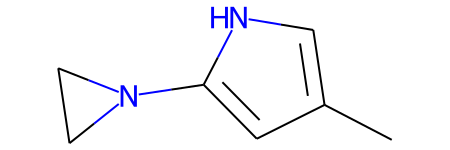

In [990]:
Chem.MolFromSmiles(train_set.iloc[idx].smiles)

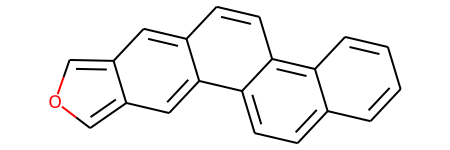

In [977]:
Chem.MolFromSmiles("c12c3ccc4c(cc5cocc5c4)c3ccc1cccc2")

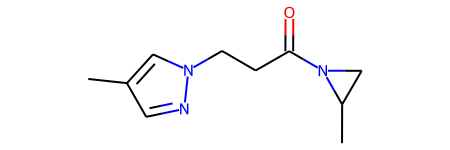

In [978]:
Chem.MolFromSmiles(s[0])

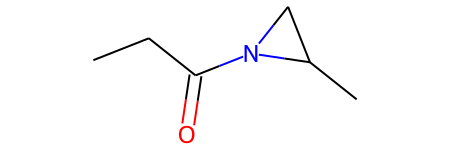

In [979]:
Chem.MolFromSmiles(s[1])

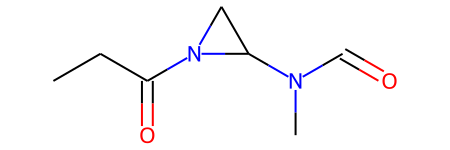

In [980]:
Chem.MolFromSmiles(s[2])

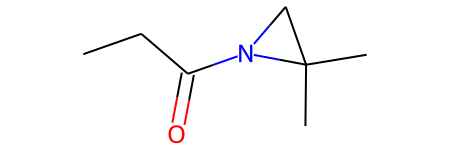

In [981]:
Chem.MolFromSmiles(s[3])

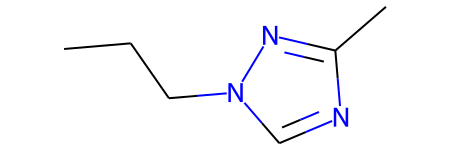

In [982]:
Chem.MolFromSmiles(s[4])

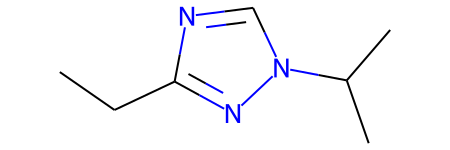

In [983]:
Chem.MolFromSmiles(s[5])

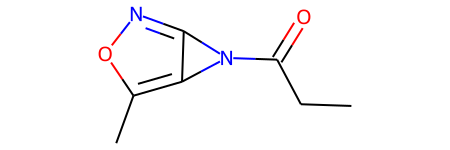

In [984]:
Chem.MolFromSmiles(s[6])

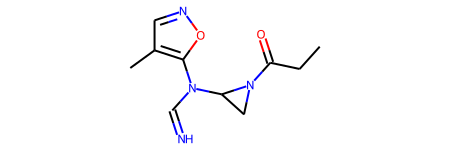

In [985]:
Chem.MolFromSmiles(s[7])

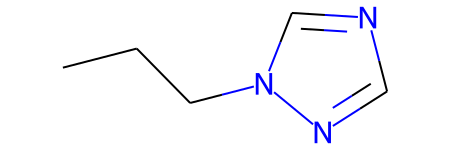

In [986]:
Chem.MolFromSmiles(s[8])

# N-closest approach

### Data extraction

In [14]:
vocab_path = "data/merged/vocab.txt"
vocab = [x.strip("\r\n ") for x in open(vocab_path)]
cset = set(vocab)
vocab = Vocab(vocab)
scale = 27.21

data = pd.read_csv("data/merged/all.txt")

df_train = pd.read_csv("data/merged/csv/train_reg.csv")
df_test = pd.read_csv("data/merged/csv/test_reg.csv")
df_val = pd.read_csv("data/merged/csv/val_reg.csv")

df_train.homo = df_train.homo*scale
df_train.lumo = df_train.lumo*scale
df_train.gap = df_train.gap*scale

df_test.homo = df_test.homo*scale
df_test.lumo = df_test.lumo*scale
df_test.gap = df_test.gap*scale

df_val.homo = df_val.homo*scale
df_val.lumo = df_val.lumo*scale
df_val.gap = df_val.gap*scale

### Tree creation

In [15]:
df = df_train

lines = []
size, cols = df.shape
pbar = tqdm(range(size))


for i in pbar:
    line = df.loc[i]
    mol_tree = MolTree(line.smiles)
    mol_tree.recover()
    mol_tree.assemble()
    lines.append([mol_tree, line.homo, line.lumo, line.gap])

tree_train = pd.DataFrame(lines, columns = columns)

100% 121940/121940 [5:07:21<00:00,  6.61it/s]   


In [ ]:
df = df_test

lines = []
size, cols = df.shape
pbar = tqdm(range(size))


for i in pbar:
    line = df.loc[i]
    mol_tree = MolTree(line.smiles)
    mol_tree.recover()
    mol_tree.assemble()
    lines.append([mol_tree, line.homo, line.lumo, line.gap])
    
tree_test = pd.DataFrame(lines, columns = columns)

100% 5000/5000 [13:37<00:00,  6.12it/s]  


In [ ]:
df = df_val

lines = []
size, cols = df.shape
pbar = tqdm(range(size))


for i in pbar:
    line = df.loc[i]
    mol_tree = MolTree(line.smiles)
    mol_tree.recover()
    mol_tree.assemble()
    lines.append([mol_tree, line.homo, line.lumo, line.gap])
    
tree_val = pd.DataFrame(lines, columns = columns)

100% 2500/2500 [06:03<00:00,  6.87it/s]


### Model loading

In [ ]:
vocab_path = "data/merged/vocab.txt"
vocab = [x.strip("\r\n ") for x in open(vocab_path)]
cset = set(vocab)
vocab = Vocab(vocab)

hidden_size = 612
latent_size = 256
depth = 3
stereo = True
batch_size = 8192
random_state = 42

modelvae_path = 'reg_model/merged_qdb9_256_612_homo/decoder_bigger_batch/model'
regressorvae_path = 'reg_model/merged_qdb9_256_612_homo/model_regression'

model = JTNNVAE(vocab, hidden_size, latent_size, depth, stereo=stereo)
regressor = nn.Sequential(
    nn.Linear(latent_size, 4096),
    nn.ReLU(),
    nn.Linear(4096, 4096),
    nn.ReLU(),
    nn.Linear(4096, 1),
)

model.load_state_dict(torch.load(modelvae_path))
regressor.load_state_dict(torch.load(regressorvae_path))

model = model.cuda()
regressor = regressor.cuda()

### Embedding extraction

In [157]:
X_train = pd.DataFrame(columns=[str(x) for x in range(latent_size)])
y_train = pd.DataFrame(columns=["homo", "lumo", "gap"])

df = tree_train
size, cols = df.shape

with torch.no_grad():
    batch_count = math.ceil(size/batch_size)
    pbar = tqdm(range(batch_count))
    
    for i in pbar:        
        _, tree_vec, mol_vec = model.encode(list(df[batch_size*i: batch_size*(i+1)]["tree"]))
        tree_mean = model.T_mean(tree_vec)
        mol_mean = model.G_mean(mol_vec)
        features = torch.cuda.FloatTensor(torch.cat([tree_mean,mol_mean], dim=1))
        X_train = X_train.append(pd.DataFrame(features.cpu().numpy(), columns=X_train.columns),ignore_index=True)
        y_train = y_train.append(df[batch_size*i: batch_size*(i+1)][["homo", "lumo", "gap"]],ignore_index=True)

100% 15/15 [02:52<00:00, 11.53s/it]


In [159]:
X_test = pd.DataFrame(columns=[str(x) for x in range(latent_size)])
y_test = pd.DataFrame(columns=["homo", "lumo", "gap"])
df = tree_test
size, cols = df.shape

with torch.no_grad():
    batch_count = math.ceil(size/batch_size)
    pbar = tqdm(range(batch_count))
    
    for i in pbar:        
        _, tree_vec, mol_vec = model.encode(list(df[batch_size*i: batch_size*(i+1)]["tree"]))
        tree_mean = model.T_mean(tree_vec)
        mol_mean = model.G_mean(mol_vec)
        features = torch.cuda.FloatTensor(torch.cat([tree_mean,mol_mean], dim=1))
        X_test = X_test.append(pd.DataFrame(features.cpu().numpy(), columns=X_test.columns),ignore_index=True)
        y_test = y_test.append(df[batch_size*i: batch_size*(i+1)][["homo", "lumo", "gap"]],ignore_index=True)

100% 1/1 [00:06<00:00,  6.67s/it]


In [160]:
X_val = pd.DataFrame(columns=[str(x) for x in range(latent_size)])
y_val = pd.DataFrame(columns=["homo", "lumo", "gap"])
df = tree_val
size, cols = df.shape

with torch.no_grad():
    batch_count = math.ceil(size/batch_size)
    pbar = tqdm(range(batch_count))
    
    for i in pbar:        
        _, tree_vec, mol_vec = model.encode(list(df[batch_size*i: batch_size*(i+1)]["tree"]))
        tree_mean = model.T_mean(tree_vec)
        mol_mean = model.G_mean(mol_vec)
        features = torch.cuda.FloatTensor(torch.cat([tree_mean,mol_mean], dim=1))
        X_val = X_val.append(pd.DataFrame(features.cpu().numpy(), columns=X_val.columns),ignore_index=True)
        y_val = y_val.append(df[batch_size*i: batch_size*(i+1)][["homo", "lumo", "gap"]],ignore_index=True)

100% 1/1 [00:03<00:00,  3.18s/it]


In [161]:
train_smiles_set = set(tree_train.tree.apply(lambda x: clean(x.smiles)))
test_smiles_set = set(tree_test.tree.apply(lambda x: clean(x.smiles)))
val_smiles_set = set(tree_val.tree.apply(lambda x: clean(x.smiles)))

### Molecular search

In [788]:
def get_metrics(model, molecules, ss, target_molecule, target_g):
    """
    Add best cosine similarity/ smallest L2 norm to hidden vectors as a metric 
    Add distance between vocabularies 
    Add cosine similarity of tree
    Add cosine similarity of molecules
    Add L2 distance for tree
    Add L2 distance for molecules
    Add Levenshtain distance
    """
    
    L2_best = ((molecules - target_molecule)**2).sum(dim=1).min().item()
    Cosine_best = torch.nn.functional.cosine_similarity(target_molecule, molecules).max().item()
    
    tree_vec, mol_vec = torch.split(molecules, molecules.size()[1]//2, 1)
    tree_vec_target, mol_vec_target = torch.split(target_molecule, target_molecule.size()[1]//2, 1)
    
    L2_best_tree = ((tree_vec - tree_vec_target)**2).sum(dim=1).min().item()
    Cosine_best_tree = torch.nn.functional.cosine_similarity(tree_vec, tree_vec_target).max().item()
    
    L2_best_mol = ((mol_vec - mol_vec_target)**2).sum(dim=1).min().item()
    Cosine_best_mol = torch.nn.functional.cosine_similarity(mol_vec, mol_vec_target).max().item()
    
    binary_smiles = []
    for s in ss:
        try:
            mol = MolTree(s)
            binary_h = [0]*vocab.size()
            for c in mol.nodes:
                binary_h[vocab.get_index(c.smiles)] = 1

            binary_smiles.append(binary_h)
        except BaseException:
            continue

    binary_smiles = torch.tensor(binary_smiles, device = torch.device("cuda"))
    
    target = [[0]*vocab.size()]
    
    for n in target_g.nodes:
        try:
            target[0][vocab.get_index(n.smiles)] = 1
        except KeyError:
            continue
        
    target = torch.tensor(target, device = torch.device("cuda"))
    dice = (2*(binary_smiles*target).sum(1)/(binary_smiles.sum(1) + target.sum(1))).max().item()
    tanimoto = ((binary_smiles*target).sum(1)/(((binary_smiles + target) > 0).sum(1))).max().item()
    lev = np.min([Lev(target_g.smiles, s) for s in ss])
    
    _, tree_vec_target, mol_vec_target = model.encode([tree_t])
    tree_mean = model.T_mean(tree_vec_target)
    tree_var = torch.exp(-torch.abs(model.T_var(tree_vec_target)))
    mol_mean = model.G_mean(mol_vec_target)
    mol_var = torch.exp(-torch.abs(model.G_var(mol_vec_target)))

    mu, sigma = torch.cat([tree_mean,mol_mean], dim=1), torch.cat([tree_var,mol_var], dim=1)
    
    H = 1/torch.sqrt(2*pi*sigma)
    h = torch.exp(-(mu - molecules)**2/(2*sigma))/torch.sqrt(2*pi*sigma)
    slutskiy = (h/H).mean(dim=1).max().item()
    
    return [L2_best, Cosine_best, L2_best_tree, Cosine_best_tree, L2_best_mol, Cosine_best_mol, dice, tanimoto, lev, slutskiy]

In [837]:
df_sample = pd.read_csv("rec_metrics/metric_1.csv", index_col=0)
df_sample.head()

,L2,Cosine,L2 Tree,Cosine Tree,L2 Mol,Cosine Mol,Dice,Tanimoto,Levenshtein,Slutskiy
0,0.094504,0.999745,0.052865,0.999841,0.041638,0.999239,0.4,0.250000,8.0,0.213345
1,0.139899,0.999778,0.071955,0.999888,0.067943,0.998485,0.4,0.250000,7.0,0.090336
2,0.373810,0.999265,0.186959,0.999633,0.186852,0.997045,0.4,0.250000,8.0,0.159024
3,0.085093,0.999830,0.036475,0.999917,0.048618,0.999205,0.5,0.333333,4.0,0.363924
4,0.948609,0.997883,0.569105,0.998494,0.379504,0.995424,0.4,0.250000,6.0,0.293727


In [839]:
df_sample = pd.read_csv("rec_metrics/metric_0.csv", index_col=0)
df_sample.head()

,L2,Cosine,L2 Tree,Cosine Tree,L2 Mol,Cosine Mol,Dice,Tanimoto,Levenshtein,Slutskiy
0,82.672607,0.813492,61.614399,0.839534,16.754122,0.735865,0.571429,0.400000,8.0,0.250847
1,152.165131,0.785993,95.094528,0.834516,51.335548,0.646757,0.750000,0.600000,10.0,0.078364
2,73.830528,0.816332,57.278667,0.836123,14.140457,0.746353,0.285714,0.166667,7.0,0.210933
3,77.289909,0.815472,60.424370,0.834558,16.414745,0.732470,0.888889,0.800000,6.0,0.303780
4,80.801628,0.809072,59.986607,0.833226,15.429569,0.742650,1.000000,1.000000,6.0,0.337377


### 0.
Starting from randomly sampled vector from hidden embeddings distributions

In [ ]:
total = 0
train_overlap = 0
test_overlap = 0
val_overlap = 0
k_processed = 0
success_map_0 = {}
metrics_0 = pd.DataFrame(columns = ["L2", "Cosine", "L2 Tree", "Cosine Tree", "L2 Mol", "Cosine Mol", "Dice", "Tanimoto", "Levenshtein", 'Slutskiy'])

try:
    
    pbar = tqdm(range(k_processed, tree_val.shape[0]))
    for k in pbar:
        tree_t, homo, lumo, gap = tree_val.iloc[k]
        lr_mol, n_steps = 0.01, 150
        loss = nn.MSELoss(reduction="mean")
        tree_t.smiles = clean(tree_t.smiles)

        target = [homo]
        size = [100, 256]
        molecules = torch.rand(size, device=torch.device("cuda"))*torch.tensor(X_val.std(), device=torch.device("cuda")) + torch.tensor(X_val.mean(), device=torch.device("cuda")) 
        molecules.requires_grad = True
        target = torch.FloatTensor(target)
        target = target.to(torch.device("cuda"))
        optimizer = optim.Adam([molecules], lr=lr_mol)

        props = latent_space_descent(molecules, target.repeat((100, 1)), regressor, nn.MSELoss(reduction="mean"), optimizer, 100)

        clear_output(wait=True)        
        tree_vec, mol_vec = torch.split(molecules, molecules.size()[1]//2, 1)

        s = set()

        for i, (tree, mol) in enumerate(zip(tree_vec, mol_vec)):
            _s = model.decode(tree[None, :],mol[None, :], False)
            if _s is not None:
                _s = smiles(model.decode(tree[None, :],mol[None, :], False))
                _s.clean_stereo()
                _s.canonicalize()

                s.add(_s.__str__())

        train_overlap += len(train_smiles_set.intersection(s))
        test_overlap += len(test_smiles_set.intersection(s))
        val_overlap += len(val_smiles_set.intersection(s))

        df_line = get_metrics(model, molecules, s, torch.tensor(X_val.iloc[k], device=torch.device("cuda"))[None, :], tree_t)
        metrics_0 = metrics_0.append(pd.Series(df_line, index = metrics_0.columns), ignore_index=True)
        metrics_0.to_csv("rec_metrics/metric_0.csv")

        if tree_t.smiles in s:
            success_map_0[total] = [s, molecules.detach().cpu().clone(), torch.tensor(X_val.iloc[k], device=torch.device("cuda"))[None, :], tree_t]
            total +=1

        print("Iteration {}, Success rate: {}".format(k+1, (total)/(k+1)))
        print("Train overlap {}\nTest overlap {}\nValidation overlap {}\n".format(train_overlap/((k+1)*100),
                                                                                  test_overlap/((k+1)*100),
                                                                                  val_overlap/((k+1)*100)))
except BaseException as e:
    with open("rec_metrics/error_0.txt", "w") as f:
        f.write(e.__doc__)
        f.write(e.__str__())

total_0 = total
train_overlap_0 = train_overlap
test_overlap_0 = test_overlap
val_overlap_0 = val_overlap
k_processed = k

clear_output()
text = ""
text += "Iteration {}, Success rate: {} \n".format(k_processed+1, (total_0)/(k_processed+1))
text += "Train overlap {}\nTest overlap {}\nValidation overlap {}\n".format(train_overlap_0/((k_processed+1)*100),
                                                                          test_overlap_0/((k_processed+1)*100),
                                                                          val_overlap_0/((k_processed+1)*100))
print(text)
with open("rec_metrics/result_0.txt", "w") as f:
    f.write(text)

  8% 204/2500 [1:19:43<14:59:24, 23.50s/it]

Iteration 204, Success rate: 0.0
Train overlap 0.32573529411764707
Test overlap 0.00784313725490196
Validation overlap 0.004803921568627451



### 1.

Starting from changed example vector

In [ ]:
total = 0
train_overlap = 0
test_overlap = 0
val_overlap = 0
k_processed = 0
success_map_1 = {}
metrics_1 = pd.DataFrame(columns = ["L2", "Cosine", "L2 Tree", "Cosine Tree", "L2 Mol", "Cosine Mol", "Dice", "Tanimoto", "Levenshtein", 'Slutskiy'])

try:
    
    pbar = tqdm(range(k_processed, tree_val.shape[0]))
    for k in pbar:
        tree_t, homo, lumo, gap = tree_val.iloc[k]
        lr_mol, n_steps = 0.01, 150
        loss = nn.MSELoss(reduction="mean")
        ss = clean(tree_t.smiles)
        
        target = [homo]
        size = [99, 256]
        
        idx = (((tree_train.homo - target)**2)).argmin()
        
        multiplier = torch.cat((torch.ones(1,256, device=torch.device("cuda")), (torch.rand(size, device=torch.device("cuda"))-0.5)*torch.tensor(X_train.std(), device=torch.device("cuda"))))
        molecules = torch.tensor(X_train.iloc[idx], device=torch.device("cuda"))*multiplier
        molecules.requires_grad = True
        
        target = torch.FloatTensor(target)
        target = target.to(torch.device("cuda"))
        optimizer = optim.Adam([molecules], lr=lr_mol)

        props = latent_space_descent(molecules, target.repeat((size[0]+1, 1)), regressor, nn.MSELoss(reduction="mean"), optimizer, n_steps)

        clear_output(wait=True)        
        tree_vec, mol_vec = torch.split(molecules, molecules.size()[1]//2, 1)

        s = set()

        for i, (tree, mol) in enumerate(zip(tree_vec, mol_vec)):
            _s = model.decode(tree[None, :],mol[None, :], False)
            if _s is not None:
                _s = smiles(model.decode(tree[None, :],mol[None, :], False))
                _s.clean_stereo()
                _s.canonicalize()

                s.add(_s.__str__())

        train_overlap += len(train_smiles_set.intersection(s))
        test_overlap += len(test_smiles_set.intersection(s))
        val_overlap += len(val_smiles_set.intersection(s))

        
        df_line = get_metrics(model, molecules, s, torch.tensor(X_val.iloc[k], device=torch.device("cuda"))[None, :], tree_t)
        metrics_1 = metrics_1.append(pd.Series(df_line, index = metrics_1.columns), ignore_index=True)
        metrics_1.to_csv("rec_metrics/metric_1.csv")
        
        if ss in s:
            success_map_1[total] = [molecules.detach().clone(), s, torch.tensor(X_val.iloc[k], device=torch.device("cuda"))[None, :], tree_t]
            total +=1
        
        print("Iteration {}, Success rate: {}".format(k+1, (total)/(k+1)))
        print("Train overlap {}\nTest overlap {}\nValidation overlap {}\n".format(train_overlap/((k+1)),
                                                                                  test_overlap/((k+1)),
                                                                                  val_overlap/((k+1))))
except BaseException as e:
    with open("rec_metrics/error_1.txt", "w") as f:
        f.write(e.__doc__)
        f.write(e.__str__())


total_1 = total
train_overlap_1 = train_overlap
test_overlap_1 = test_overlap
val_overlap_1 = val_overlap
k_processed = k
    
clear_output()

text = ""
text += "Iteration {}, Success rate: {} \n".format(k_processed+1, (total_1)/(k_processed+1))
text += "Train overlap {}\nTest overlap {}\nValidation overlap {}\n".format(train_overlap_1/((k_processed+1)*100),
                                                                          test_overlap_1/((k_processed+1)*100),
                                                                          val_overlap_1/((k_processed+1)*100))
print(text)
with open("rec_metrics/result_1.txt", "w") as f:
    f.write(text)

### 2.
Taking the closest molecule by hidden vector representation

In [ ]:
total = 0
train_overlap = 0
test_overlap = 0
val_overlap = 0
k_processed = 0
success_map_2 = {}
metrics_2 = pd.DataFrame(columns = ["L2", "Cosine", "L2 Tree", "Cosine Tree", "L2 Mol", "Cosine Mol", "Dice", "Tanimoto", "Levenshtein", 'Slutskiy'])

try:
    
    pbar = tqdm(range(k_processed, tree_val.shape[0]))
    for k in pbar:
        tree_t, homo, lumo, gap = tree_val.iloc[k]
        lr_mol, n_steps = 0.01, 150
        loss = nn.MSELoss(reduction="mean")
        tree_t.smiles = clean(tree_t.smiles)
        
        target = [homo]
        size = [99, 256]
        
        idx = ((X_train - X_val.iloc[k])**2).sum(axis=1).argmin()
        multiplier = torch.cat((torch.ones(1,256, device=torch.device("cuda")), (torch.rand(size, device=torch.device("cuda"))-0.5)*torch.tensor(X_train.std(), device=torch.device("cuda"))))
        molecules = torch.tensor(X_train.iloc[idx], device=torch.device("cuda"))*multiplier
        molecules.requires_grad = True
        
        target = torch.FloatTensor(target)
        target = target.to(torch.device("cuda"))
        optimizer = optim.Adam([molecules], lr=lr_mol)

        props = latent_space_descent(molecules, target.repeat((size[0]+1, 1)), regressor, nn.MSELoss(reduction="mean"), optimizer, n_steps)

        clear_output(wait=True)        
        tree_vec, mol_vec = torch.split(molecules, molecules.size()[1]//2, 1)

        s = set()

        for i, (tree, mol) in enumerate(zip(tree_vec, mol_vec)):
            _s = model.decode(tree[None, :],mol[None, :], False)
            if _s is not None:
                _s = smiles(model.decode(tree[None, :],mol[None, :], False))
                _s.clean_stereo()
                _s.canonicalize()

                s.add(_s.__str__())

        train_overlap += len(train_smiles_set.intersection(s))
        test_overlap += len(test_smiles_set.intersection(s))
        val_overlap += len(val_smiles_set.intersection(s))

        
        df_line = get_metrics(model, molecules, s, torch.tensor(X_val.iloc[k], device=torch.device("cuda"))[None, :], tree_t)
        metrics_2 = metrics_2.append(pd.Series(df_line, index = metrics_2.columns), ignore_index=True)
        metrics_2.to_csv("rec_metrics/metric_2.csv")
        
        if tree_t.smiles in s:
            success_map_2[total] = [s, molecules.detach().cpu().clone(), torch.tensor(X_val.iloc[k], device=torch.device("cuda"))[None, :], tree_t]
            total +=1
            
        print("Iteration {}, Success rate: {}".format(k+1, (total)/(k+1)))
        print("Train overlap {}\nTest overlap {}\nValidation overlap {}\n".format(train_overlap/((k+1)),
                                                                                  test_overlap/((k+1)),
                                                                                  val_overlap/((k+1))))
except BaseException as e:
    with open("rec_metrics/error_2.txt", "w") as f:
        f.write(e.__doc__)
        f.write(e.__str__())

total_2 = total
train_overlap_2 = train_overlap
test_overlap_2 = test_overlap
val_overlap_2 = val_overlap
k_processed = k
    
clear_output()

text = ""
text += "Iteration {}, Success rate: {} \n".format(k_processed+1, (total_2)/(k_processed+1))
text += "Train overlap {}\nTest overlap {}\nValidation overlap {}\n".format(train_overlap_2/((k_processed+1)*100),
                                                                          test_overlap_2/((k_processed+1)*100),
                                                                          val_overlap_2/((k_processed+1)*100))
print(text)
with open("rec_metrics/result_2.txt", "w") as f:
    f.write(text)

### 3. 
The Same as 0 but with double descent

In [ ]:
total = 0
train_overlap = 0
test_overlap = 0
val_overlap = 0
k_processed = 0
success_map_3 = {}
metrics_3 = pd.DataFrame(columns = ["L2", "Cosine", "L2 Tree", "Cosine Tree", "L2 Mol", "Cosine Mol", "Dice", "Tanimoto", "Levenshtein", 'Slutskiy'])


try:
    pbar = tqdm(range(k_processed, tree_val.shape[0]))
    for k in pbar:
        tree_t, homo, lumo, gap = tree_val.iloc[k]
        lr_mol, n_steps = 0.01, 150
        loss = nn.MSELoss(reduction="mean")
        tree_t.smiles = clean(tree_t.smiles)
        
        target = [homo]
        size = [100, 256]
        molecules = torch.rand(size, device=torch.device("cuda"))*torch.tensor(X_val.std(), device=torch.device("cuda")) + torch.tensor(X_val.mean(), device=torch.device("cuda")) 
        molecules.requires_grad = True
        target = torch.FloatTensor(target)
        target = target.to(torch.device("cuda"))

        molecules = double_descent(molecules, target, model, regressor,  model, regressor, loss, lr_mol, n_steps = 150, n_iter=10, verbose=False)

        clear_output(wait=True)        
        tree_vec, mol_vec = torch.split(molecules, molecules.size()[1]//2, 1)

        s = set()

        for i, (tree, mol) in enumerate(zip(tree_vec, mol_vec)):
            _s = model.decode(tree[None, :],mol[None, :], False)
            if _s is not None:
                _s = smiles(model.decode(tree[None, :],mol[None, :], False))
                _s.clean_stereo()
                _s.canonicalize()

                s.add(_s.__str__())

        train_overlap += len(train_smiles_set.intersection(s))
        test_overlap += len(test_smiles_set.intersection(s))
        val_overlap += len(val_smiles_set.intersection(s))

        
        df_line = get_metrics(model, molecules, s, torch.tensor(X_val.iloc[k], device=torch.device("cuda"))[None, :], tree_t)
        metrics_3 = metrics_3.append(pd.Series(df_line, index = metrics_3.columns), ignore_index=True)
        metrics_3.to_csv("rec_metrics/metric_3.csv")
        
        if tree_t.smiles in s:
            success_map_3[total] = [molecules.detach().clone(), s, torch.tensor(X_val.iloc[k], device=torch.device("cuda"))[None, :], tree_t]
            total +=1
            
        print("Iteration {}, Success rate: {}".format(k+1, (total)/(k+1)))
        print("Train overlap {}\nTest overlap {}\nValidation overlap {}\n".format(train_overlap/((k+1)),
                                                                                  test_overlap/((k+1)),
                                                                                  val_overlap/((k+1))))
except BaseException as e:
    with open("rec_metrics/error_3.txt", "w") as f:
        f.write(e.__doc__)
        f.write(e.__str__())

total_3 = total
train_overlap_3 = train_overlap
test_overlap_3 = test_overlap
val_overlap_3 = val_overlap
k_processed = k
    
clear_output()
text = ""
text += "Iteration {}, Success rate: {} \n".format(k_processed+1, (total_3)/(k_processed+1))
text += "Train overlap {}\nTest overlap {}\nValidation overlap {}\n".format(train_overlap_3/((k_processed+1)*100),
                                                                          test_overlap_3/((k_processed+1)*100),
                                                                          val_overlap_3/((k_processed+1)*100))
print(text)
with open("rec_metrics/result_3.txt", "w") as f:
    f.write(text)

  3% 75/2500 [1:00:50<33:07:50, 49.18s/it]

Iteration 75, Success rate: 0.0
Train overlap 24.706666666666667
Test overlap 0.84
Validation overlap 0.4



### 4. 
Same as 1 but with double descent 

In [ ]:
total = 0
train_overlap = 0
test_overlap = 0
val_overlap = 0
k_processed = 0
success_map_4 = {}
metrics_4 = pd.DataFrame(columns = ["L2", "Cosine", "L2 Tree", "Cosine Tree", "L2 Mol", "Cosine Mol", "Dice", "Tanimoto", "Levenshtein", 'Slutskiy'])


try:
    
    pbar = tqdm(range(k_processed, tree_val.shape[0]))
    for k in pbar:
        tree_t, homo, lumo, gap = tree_val.iloc[k]
        lr_mol, n_steps = 0.01, 150
        loss = nn.MSELoss(reduction="mean")
        tree_t.smiles = clean(tree_t.smiles)

        target = [homo]
        size = [99, 256]


        idx = (((tree_train.homo - target)**2)).argmin()
        multiplier = torch.cat((torch.ones(1,256, device=torch.device("cuda")), (torch.rand(size, device=torch.device("cuda"))-0.5)*torch.tensor(X_train.std(), device=torch.device("cuda"))))
        molecules = torch.tensor(X_train.iloc[idx], device=torch.device("cuda"))*multiplier
        molecules.requires_grad = True


        target = torch.FloatTensor(target)
        target = target.to(torch.device("cuda"))
        optimizer = optim.Adam([molecules], lr=lr_mol)

        molecules = double_descent(molecules, target, model, regressor,  model, regressor, loss, lr_mol, n_steps = 150, n_iter=10, verbose=False)

        clear_output(wait=True)        
        tree_vec, mol_vec = torch.split(molecules, molecules.size()[1]//2, 1)

        s = set()

        for i, (tree, mol) in enumerate(zip(tree_vec, mol_vec)):
            _s = model.decode(tree[None, :],mol[None, :], False)
            if _s is not None:
                _s = smiles(model.decode(tree[None, :],mol[None, :], False))
                _s.clean_stereo()
                _s.canonicalize()

                s.add(_s.__str__())

        train_overlap += len(train_smiles_set.intersection(s))
        test_overlap += len(test_smiles_set.intersection(s))
        val_overlap += len(val_smiles_set.intersection(s))

        
        df_line = get_metrics(model, molecules, s, torch.tensor(X_val.iloc[k], device=torch.device("cuda"))[None, :], tree_t)
        metrics_4 = metrics_4.append(pd.Series(df_line, index = metrics_4.columns), ignore_index=True)
        metrics_4.to_csv("rec_metrics/metric_4.csv")
        
        if tree_t.smiles in s:
            success_map_4[total] = [molecules.detach().clone(), s, torch.tensor(X_val.iloc[k], device=torch.device("cuda"))[None, :], tree_t]
            total +=1
            
        print("Iteration {}, Success rate: {}".format(k+1, (total)/(k+1)))
        print("Train overlap {}\nTest overlap {}\nValidation overlap {}\n".format(train_overlap/((k+1)),
                                                                                  test_overlap/((k+1)),
                                                                                  val_overlap/((k+1))))
except BaseException as e:
    with open("rec_metrics/error_4.txt", "w") as f:
        f.write(e.__doc__)
        f.write(e.__str__())

clear_output()
text = ""
text += "Iteration {}, Success rate: {} \n".format(k_processed+1, (total_4)/(k_processed+1))
text += "Train overlap {}\nTest overlap {}\nValidation overlap {}\n".format(train_overlap_4/((k_processed+1)*100),
                                                                          test_overlap_4/((k_processed+1)*100),
                                                                          val_overlap_4/((k_processed+1)*100))
print(text)
with open("rec_metrics/result_4.txt", "w") as f:
    f.write(text)

  0% 4/2500 [04:06<42:34:33, 61.41s/it]

Iteration 4, Success rate: 0.0
Train overlap 10.25
Test overlap 0.25
Validation overlap 0.0



In [955]:
tree_t, homo, lumo, gap = tree_val.iloc[k]
lr_mol, n_steps = 0.01, 150
loss = nn.MSELoss(reduction="mean")
tree_t.smiles = clean(tree_t.smiles)

target = [homo]
size = [99, 256]


idx = (((tree_train.homo - target)**2)).argmin()
multiplier = torch.cat((torch.ones(1,256, device=torch.device("cuda")), (torch.rand(size, device=torch.device("cuda"))-0.5)*torch.tensor(X_train.std(), device=torch.device("cuda"))))
molecules = torch.tensor(X_train.iloc[idx], device=torch.device("cuda"))*multiplier
molecules.requires_grad = True


target = torch.FloatTensor(target)
target = target.to(torch.device("cuda"))
optimizer = optim.Adam([molecules], lr=lr_mol)

molecules = double_descent(molecules, target, model, regressor,  model, regressor, loss, lr_mol, n_steps = 150, n_iter=10, verbose=False)

(tensor([-7.6025], device='cuda:0'),
 tensor([[ 0.8201,  0.4738,  0.6883,  ...,  0.1090,  0.9040,  0.1558],
         [ 0.1695,  0.0074,  0.8473,  ...,  0.0149,  0.3282,  0.7413],
         [ 0.1825,  0.0111,  0.2454,  ...,  0.2265,  0.0664,  0.9047],
         ...,
         [ 0.6393,  0.2913, -0.4202,  ...,  0.9174,  0.2537,  0.0200],
         [ 0.4926,  0.2902, -0.0681,  ...,  0.5422,  0.2099,  0.4017],
         [ 0.2836,  0.3354,  0.4374,  ...,  0.8509,  0.6996,  0.3722]],
        device='cuda:0', requires_grad=True))

### 5.

Same as 2 but with double optimisation

In [ ]:
total = 0
train_overlap = 0
test_overlap = 0
val_overlap = 0
k_processed = 0
success_map_5 = {}
metrics_5 = pd.DataFrame(columns = ["L2", "Cosine", "L2 Tree", "Cosine Tree", "L2 Mol", "Cosine Mol", "Dice", "Tanimoto", "Levenshtein", 'Slutskiy'])

try:
    
    pbar = tqdm(range(k_processed, tree_val.shape[0]))
    for k in pbar:
        tree_t, homo, lumo, gap = tree_val.iloc[k]
        lr_mol, n_steps = 0.01, 150
        loss = nn.MSELoss(reduction="mean")
        tree_t.smiles = clean(tree_t.smiles)

        target = [homo]
        size = [99, 256]
        
        idx = ((X_train - X_val.iloc[k])**2).sum(axis=1).argmin()
        multiplier = torch.cat((torch.ones(1,256, device=torch.device("cuda")), (torch.rand(size, device=torch.device("cuda"))-0.5)*torch.tensor(X_train.std(), device=torch.device("cuda"))))
        molecules = torch.tensor(X_train.iloc[idx], device=torch.device("cuda"))*multiplier
        molecules.requires_grad = True


        target = torch.FloatTensor(target)
        target = target.to(torch.device("cuda"))
        optimizer = optim.Adam([molecules], lr=lr_mol)

        molecules = double_descent(molecules, target, model, regressor,  model, regressor, loss, lr_mol, n_steps = 150, n_iter=10, verbose=False)

        clear_output(wait=True)        
        tree_vec, mol_vec = torch.split(molecules, molecules.size()[1]//2, 1)

        s = set()

        for i, (tree, mol) in enumerate(zip(tree_vec, mol_vec)):
            _s = model.decode(tree[None, :],mol[None, :], False)
            if _s is not None:
                _s = smiles(model.decode(tree[None, :],mol[None, :], False))
                _s.clean_stereo()
                _s.canonicalize()

                s.add(_s.__str__())

        train_overlap += len(train_smiles_set.intersection(s))
        test_overlap += len(test_smiles_set.intersection(s))
        val_overlap += len(val_smiles_set.intersection(s))

        
        df_line = get_metrics(model, molecules, s, torch.tensor(X_val.iloc[k], device=torch.device("cuda"))[None, :], tree_t)
        metrics_5 = metrics_5.append(pd.Series(df_line, index = metrics_5.columns), ignore_index=True)
        metrics_5.to_csv("rec_metrics/metric_5.csv")
        
        if tree_t.smiles in s:
            success_map_5[total] = [molecules.detach().clone(), s, torch.tensor(X_val.iloc[k], device=torch.device("cuda"))[None, :], tree_t]
            total +=1
            
        print("Iteration {}, Success rate: {}".format(k+1, (total)/(k+1)))
        print("Train overlap {}\nTest overlap {}\nValidation overlap {}\n".format(train_overlap/((k+1)),
                                                                                  test_overlap/((k+1)),
                                                                                  val_overlap/((k+1))))
except BaseException as e:
    with open("rec_metrics/error_5.txt", "w") as f:
        f.write(e.__doc__)
        f.write(e.__str__())

total_5 = total
train_overlap_5 = train_overlap
test_overlap_5 = test_overlap
val_overlap_5 = val_overlap
k_processed = k

clear_output()
text = ""
text += "Iteration {}, Success rate: {} \n".format(k_processed+1, (total_5)/(k_processed+1))
text += "Train overlap {}\nTest overlap {}\nValidation overlap {}\n".format(train_overlap_5/((k_processed+1)*100),
                                                                          test_overlap_5/((k_processed+1)*100),
                                                                          val_overlap_5/((k_processed+1)*100))
print(text)
with open("rec_metrics/result_5.txt", "w") as f:
    f.write(text)

  5% 135/2500 [2:22:36<40:51:42, 62.20s/it]

## Visualisation

In [1121]:
def visualise(predicted_smiles, k = 9, target_molecule = None, target_prop = None, predicted_props = None, save_name = None):
    flag = (target_molecule is not None)
    row = math.ceil((len(predicted_smiles[:k]) + flag)/3)
    column = 3
       
    plt.figure(figsize=(18, 6*row))
                    
    if flag:
        img = Chem.Draw.MolToImage(Chem.MolFromSmiles(target_molecule))

        ax = plt.subplot(row, column, 1)
        title = target_molecule + "\n"
        if target_prop is not None:
            title += "Target: {:.4f}".format(target_prop)
        ax.set_title(title)        
        ax.axis("off")
        ax.imshow(img)
                    
    for i, mol in enumerate(predicted_smiles[:k]):
        position = 1 + i + flag
        img = Chem.Draw.MolToImage(Chem.MolFromSmiles(mol))

        ax = plt.subplot(row, column, position)
        title = mol + "\n"
                    
        if predicted_props is not None:
            title += "Prediction: {:.4f}\n".format(predicted_props[i])    
            if target_prop is not None:
                title += "MSE: {:.4f}\n".format(abs(predicted_props[i] - target_prop))
                    
        ax.set_title(title)
        ax.axis("off")
        ax.imshow(img)
    
    if save_name is not None:
        plt.savefig(save_name)
        
    plt.show()

In [1112]:
results_df

,Type,L2,Cosine,L2 Tree,Cosine Tree,L2 Mol,Cosine Mol,Dice,Tanimoto,Levenshtein,Slutskiy,Test
0,Mean 0,101.747817,0.786013,69.987354,0.820199,27.968766,0.700067,0.658716,0.520588,7.059600,0.243460,1
1,Var 0,1837.563629,0.006879,1018.769808,0.004665,460.133740,0.039467,0.036828,0.044178,3.307771,0.002537,1
2,Mean 1,153.805431,0.687728,106.848002,0.732663,29.954926,0.637420,0.646874,0.505097,7.042800,0.209869,1
3,Var 1,2282.782006,0.010001,1215.452422,0.006377,285.648168,0.039772,0.034186,0.040570,3.083802,0.002784,1
4,Mean 2,18.356830,0.963620,11.479544,0.971912,6.820896,0.930604,0.889668,0.828399,5.300400,0.435532,53
5,Var 2,116.683941,0.000395,100.635207,0.000540,42.816152,0.004818,0.022002,0.042881,7.222649,0.014597,53
6,Mean 3,229.529476,0.642669,138.537986,0.705317,81.072415,0.538500,0.630571,0.493533,7.296800,0.122954,0
7,Var 3,3442.910346,0.006539,1685.362127,0.005349,713.089981,0.023122,0.043733,0.048922,3.276420,0.001539,0
8,Mean 4,278.006551,0.275696,204.545754,0.269577,58.857684,0.434878,0.613870,0.471500,7.683200,0.155721,0
9,Var 4,3449.500631,0.031363,2805.245664,0.039290,311.222135,0.028939,0.037824,0.043202,3.134492,0.001064,0


In [1115]:
results_df.iloc[[1, 3, 5, 7, 9, 11]]

,Type,L2,Cosine,L2 Tree,Cosine Tree,L2 Mol,Cosine Mol,Dice,Tanimoto,Levenshtein,Slutskiy,Test
1,Var 0,1837.563629,0.006879,1018.769808,0.004665,460.133740,0.039467,0.036828,0.044178,3.307771,0.002537,1
3,Var 1,2282.782006,0.010001,1215.452422,0.006377,285.648168,0.039772,0.034186,0.040570,3.083802,0.002784,1
5,Var 2,116.683941,0.000395,100.635207,0.000540,42.816152,0.004818,0.022002,0.042881,7.222649,0.014597,53
7,Var 3,3442.910346,0.006539,1685.362127,0.005349,713.089981,0.023122,0.043733,0.048922,3.276420,0.001539,0
9,Var 4,3449.500631,0.031363,2805.245664,0.039290,311.222135,0.028939,0.037824,0.043202,3.134492,0.001064,0
11,Var 5,9334.699909,0.069703,6403.419769,0.078538,396.687346,0.044618,0.048156,0.065352,4.877619,0.009649,20


In [1114]:
results_df.iloc[[0, 2, 4, 6, 8, 10]]

,Type,L2,Cosine,L2 Tree,Cosine Tree,L2 Mol,Cosine Mol,Dice,Tanimoto,Levenshtein,Slutskiy,Test
0,Mean 0,101.747817,0.786013,69.987354,0.820199,27.968766,0.700067,0.658716,0.520588,7.0596,0.243460,1
2,Mean 1,153.805431,0.687728,106.848002,0.732663,29.954926,0.637420,0.646874,0.505097,7.0428,0.209869,1
4,Mean 2,18.356830,0.963620,11.479544,0.971912,6.820896,0.930604,0.889668,0.828399,5.3004,0.435532,53
6,Mean 3,229.529476,0.642669,138.537986,0.705317,81.072415,0.538500,0.630571,0.493533,7.2968,0.122954,0
8,Mean 4,278.006551,0.275696,204.545754,0.269577,58.857684,0.434878,0.613870,0.471500,7.6832,0.155721,0
10,Mean 5,248.003754,0.343758,183.304615,0.330803,52.829414,0.516237,0.660888,0.534650,7.2904,0.178734,20


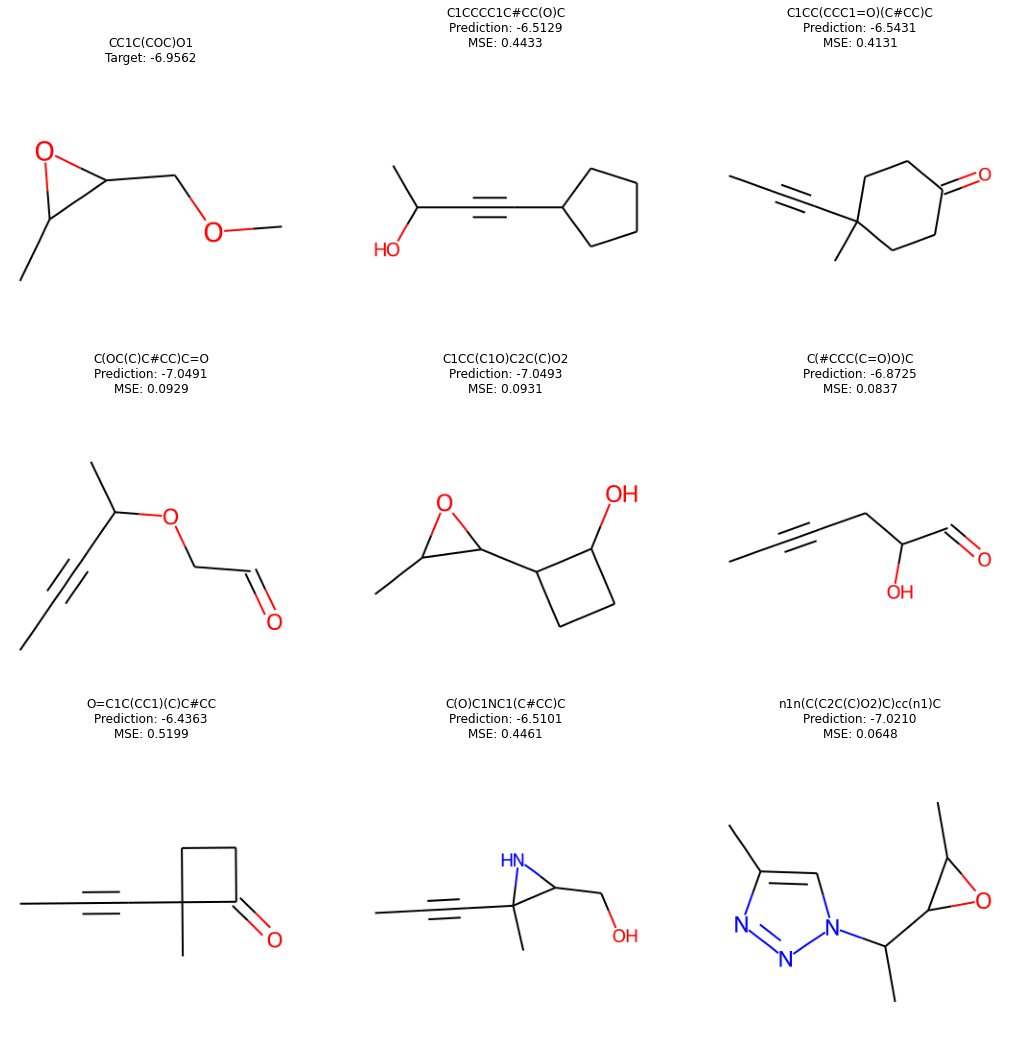

In [1138]:
pr = regressor(model.encode_latent_mean(list(success_map_0[0][0])))
visualise(list(success_map_0[0][0]),
          k = 8,
          target_molecule = success_map_0[0][3].smiles,
          target_prop = regressor(success_map_0[0][2]).item(),
          predicted_props=pr.flatten().tolist(),
          save_name = "rec_metrics/exp0_0.pdf")

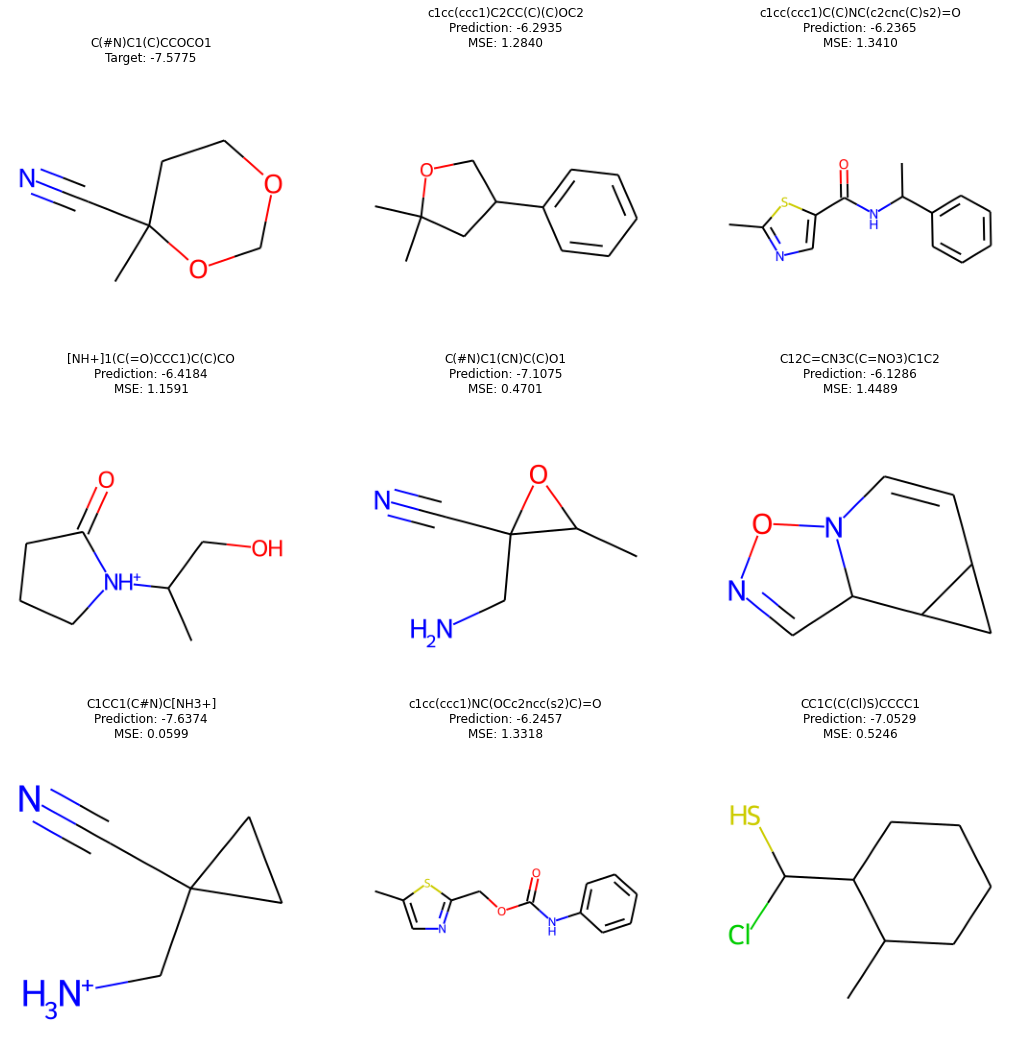

In [1144]:
pr = regressor(model.encode_latent_mean(list(success_map_1[0][1])))
visualise(list(success_map_1[0][1])[40:],
          k = 8,
          target_molecule = success_map_1[0][3].smiles,
          target_prop = regressor(success_map_1[0][2]).item(),
          predicted_props=pr.flatten().tolist()[40:],
          save_name = "rec_metrics/exp1_3.pdf")

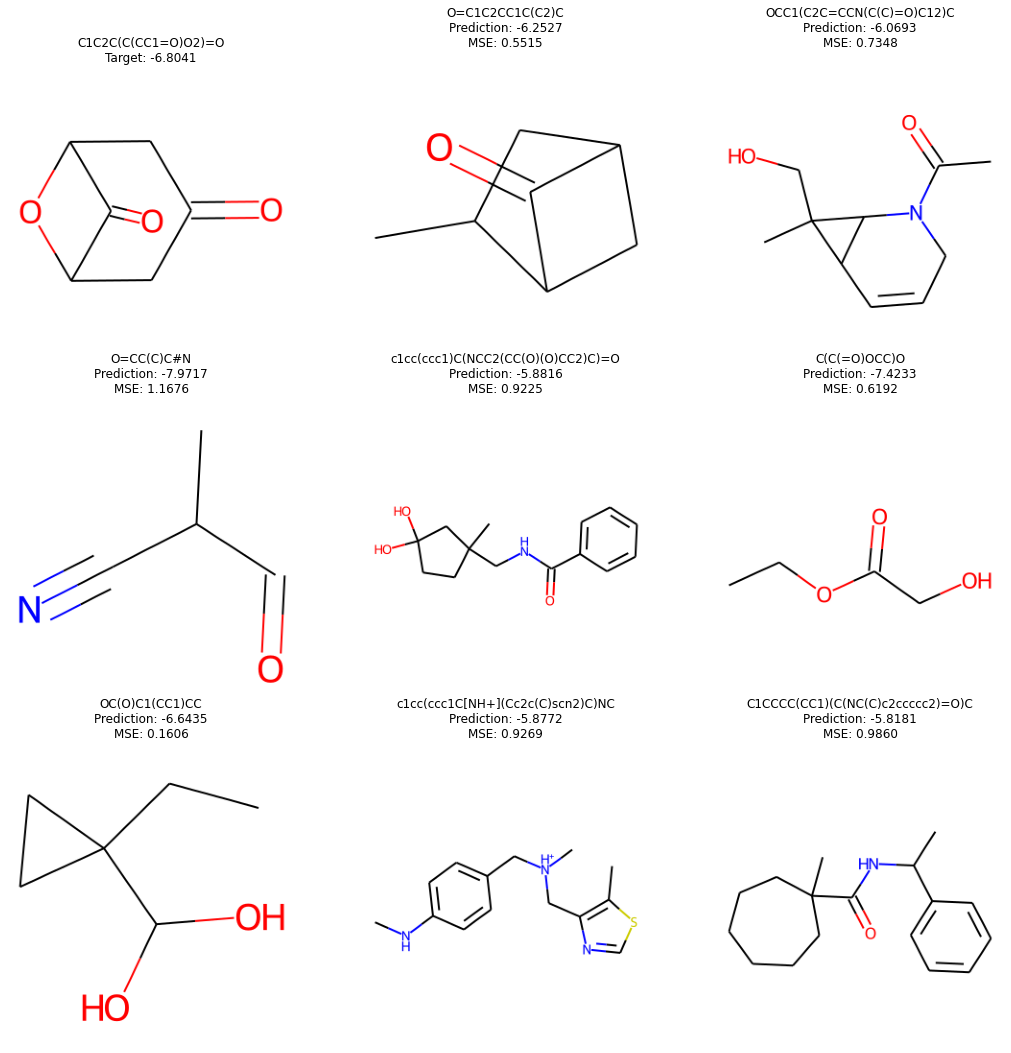

In [1107]:
pr = regressor(model.encode_latent_mean(list(success_map_2[0][0])))
visualise(list(success_map_2[0][0]),
          k = 8,
          target_molecule = success_map_2[0][3].smiles,
          target_prop = regressor(success_map_2[0][2]).item(),
          predicted_props=pr.flatten().tolist())

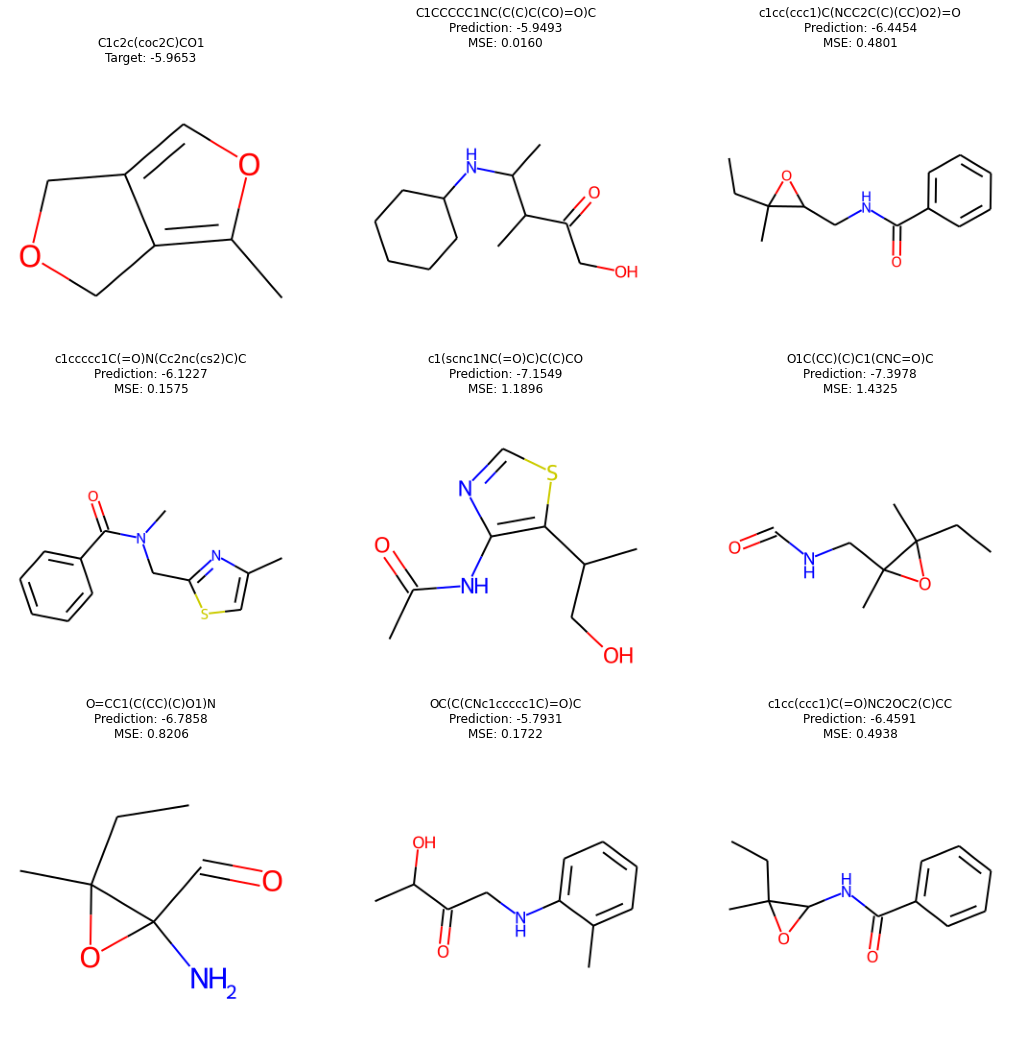

In [1111]:
pr = regressor(model.encode_latent_mean(list(success_map_5[0][1])))
visualise(list(success_map_5[0][1]),
          k = 8,
          target_molecule = success_map_5[0][3].smiles,
          target_prop = regressor(success_map_5[0][2]).item(),
          predicted_props=pr.flatten().tolist())

In [1173]:
success_map_2[0][3].smiles

'C1C2C(C(CC1=O)O2)=O'

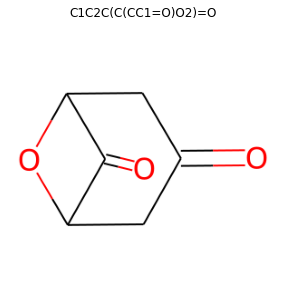

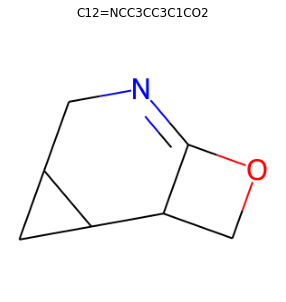

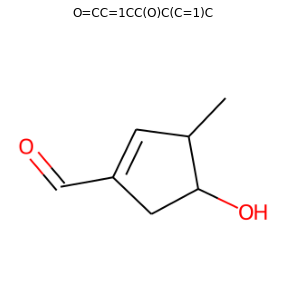

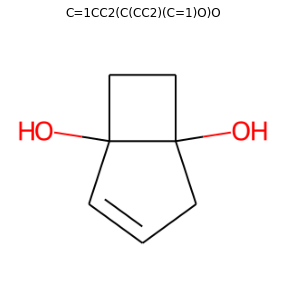

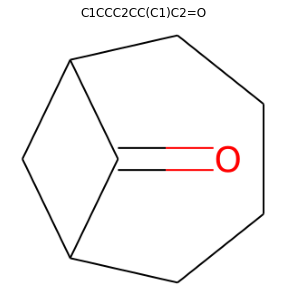

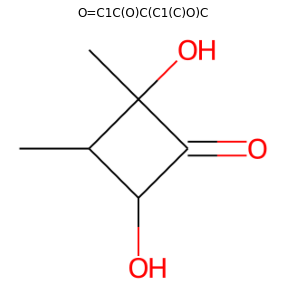

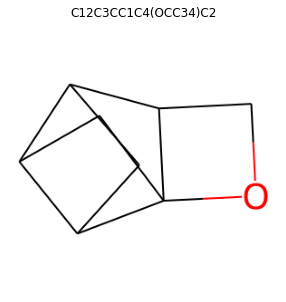

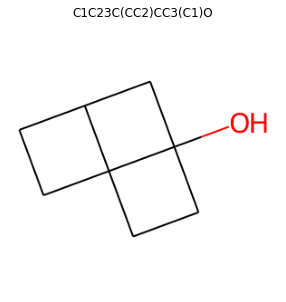

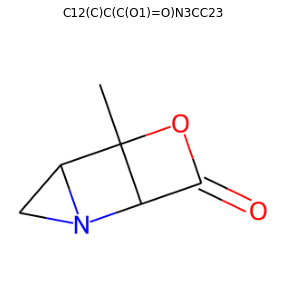

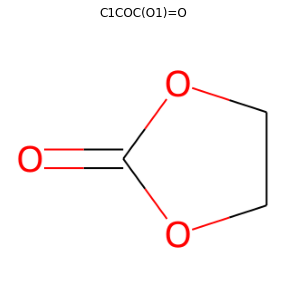

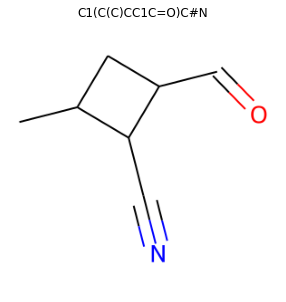

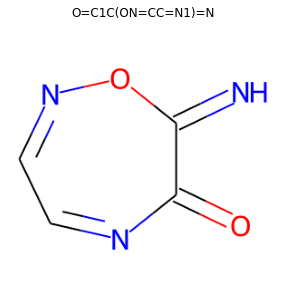

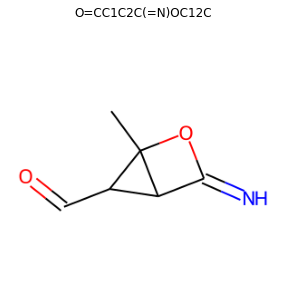

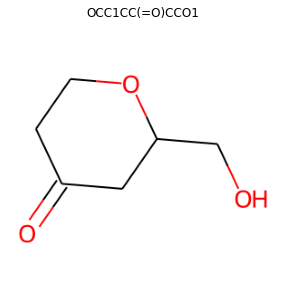

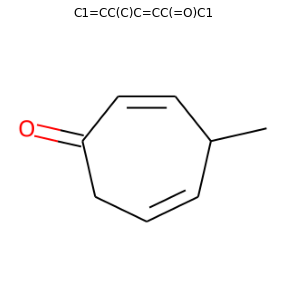

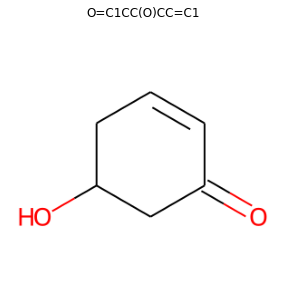

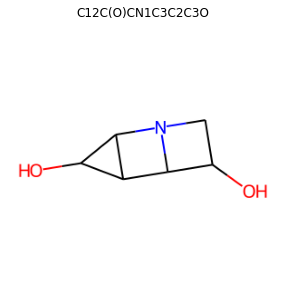

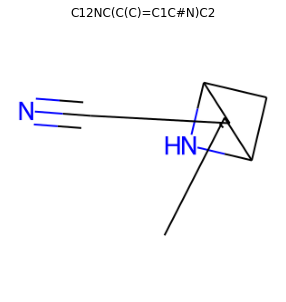

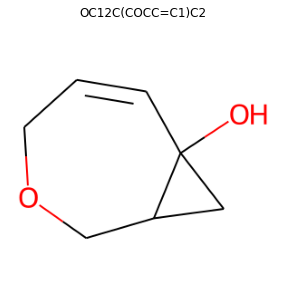

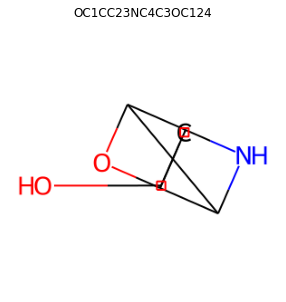

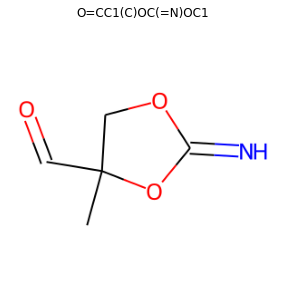

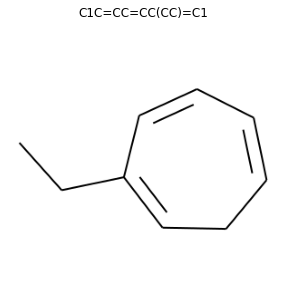

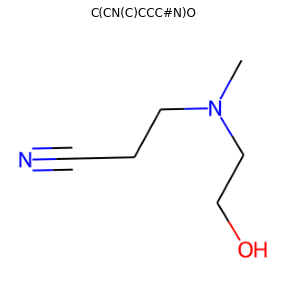

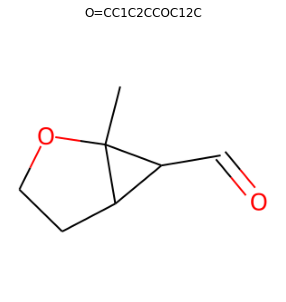

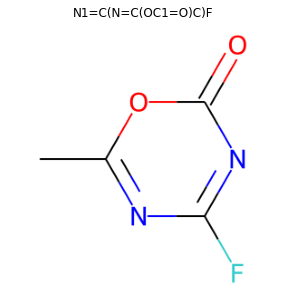

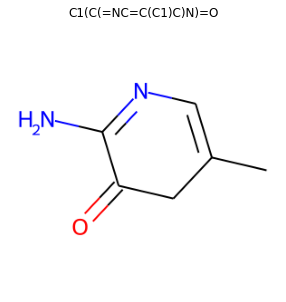

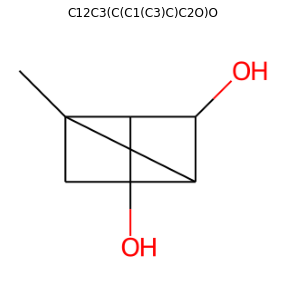

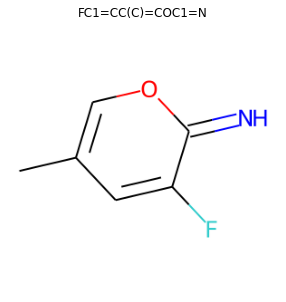

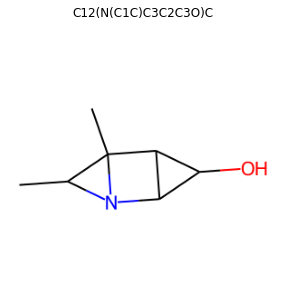

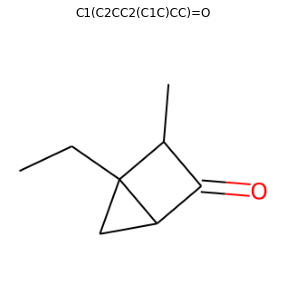

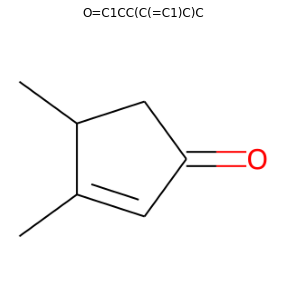

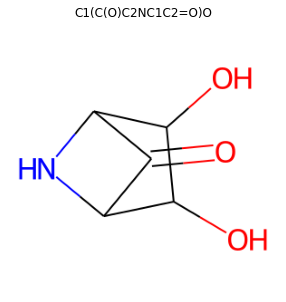

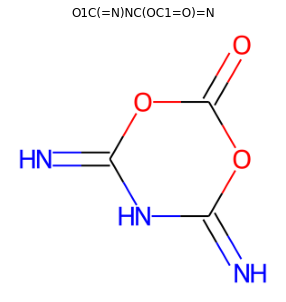

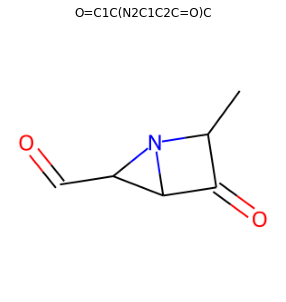

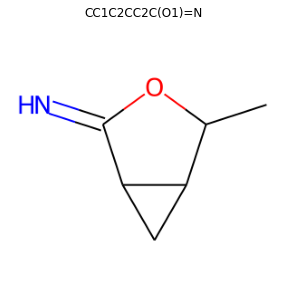

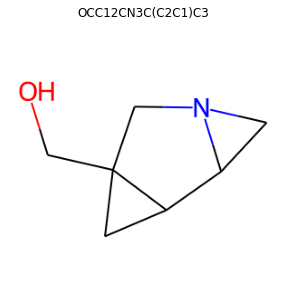

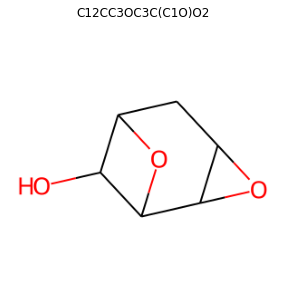

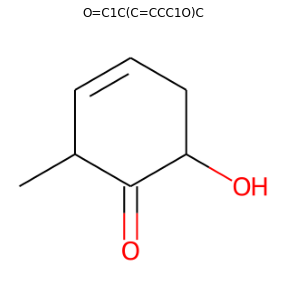

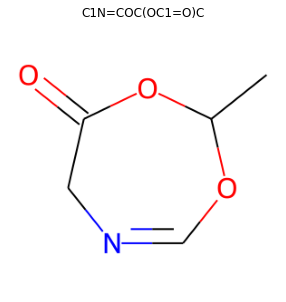

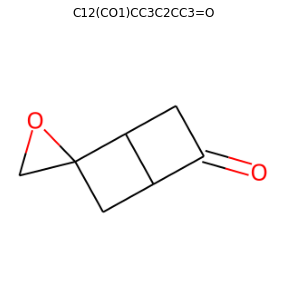

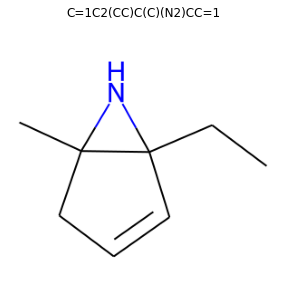

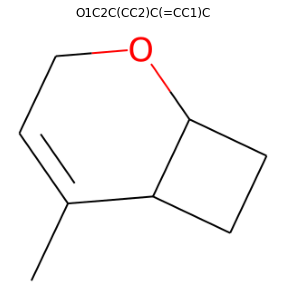

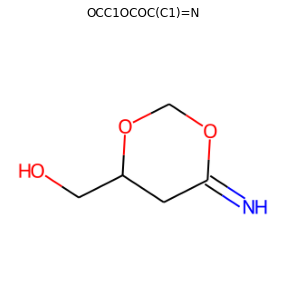

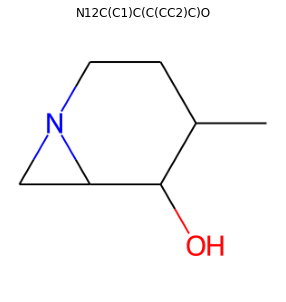

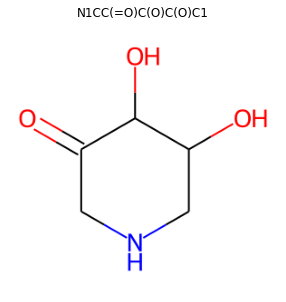

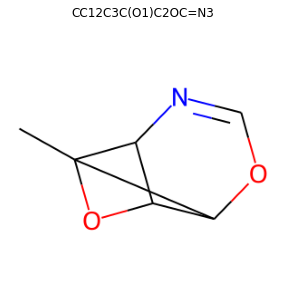

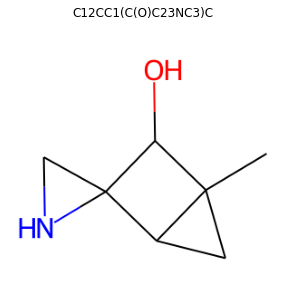

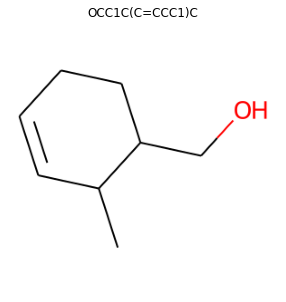

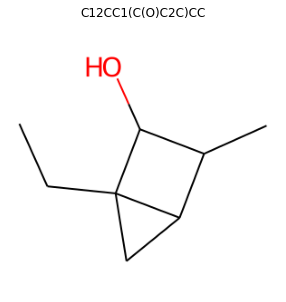

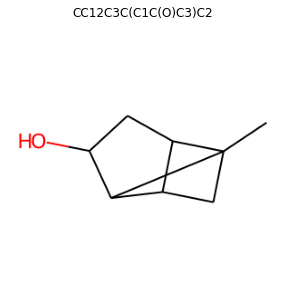

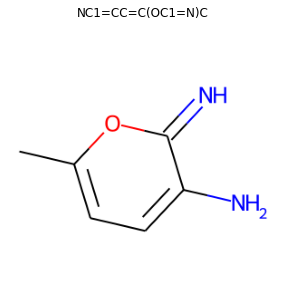

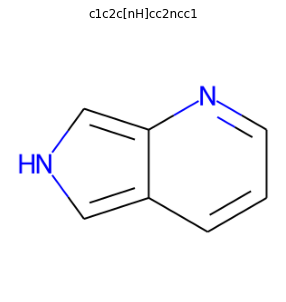

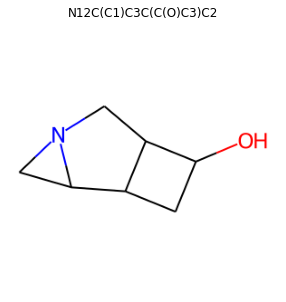

In [1151]:
for i, (key, mapping) in enumerate(success_map_2.items()):
    img = Chem.Draw.MolToImage(Chem.MolFromSmiles(mapping[3].smiles))
    plt.figure(figsize=(15, 5))
    plt.imshow(img)
    plt.title(mapping[3].smiles)
    plt.axis("off")
    plt.savefig("rec_metrics/best_2/mol_{}.pdf".format(i))
    plt.show()

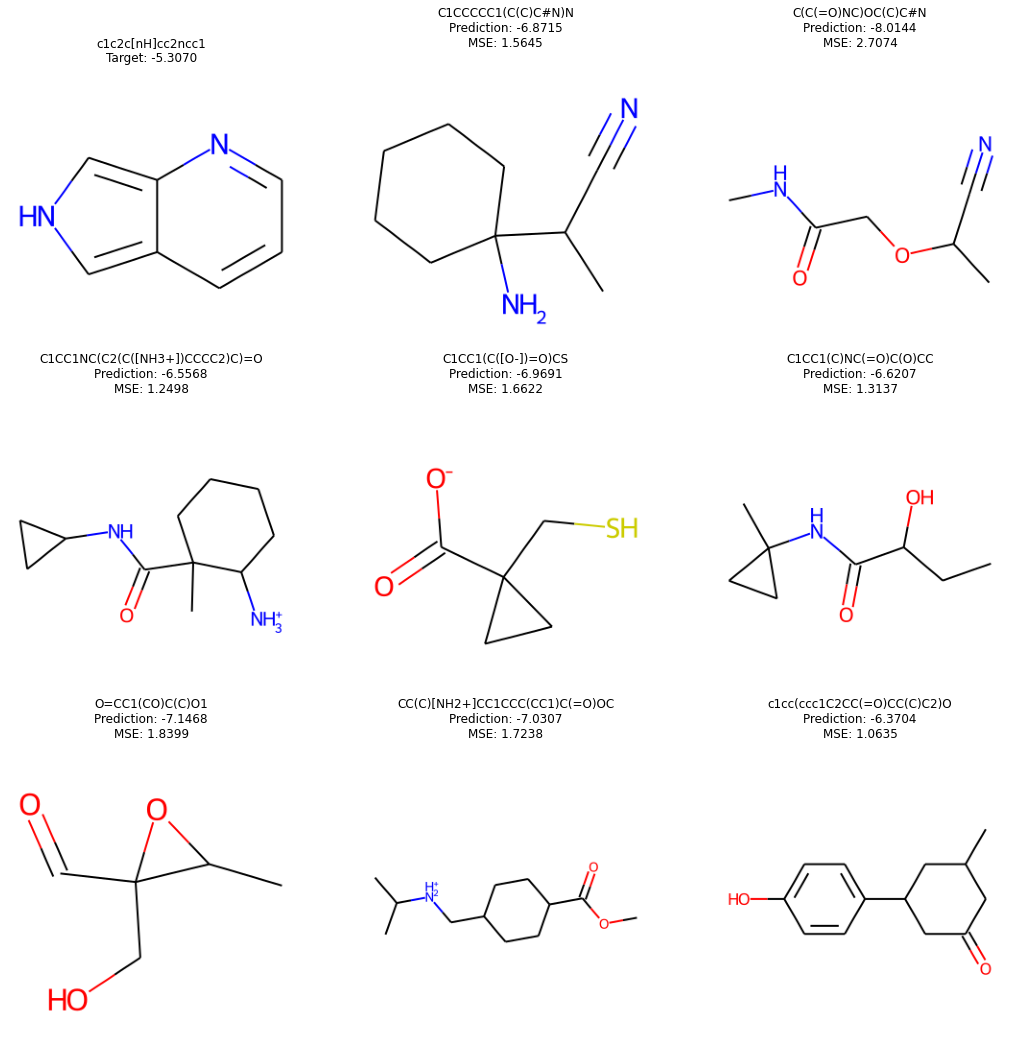

In [1157]:
pr = regressor(model.encode_latent_mean(list(success_map_2[51][0])))
visualise(list(success_map_2[51][0]),
          k = 8,
          target_molecule = success_map_2[51][3].smiles,
          target_prop = regressor(success_map_2[51][2]).item(),
          predicted_props=pr.flatten().tolist())

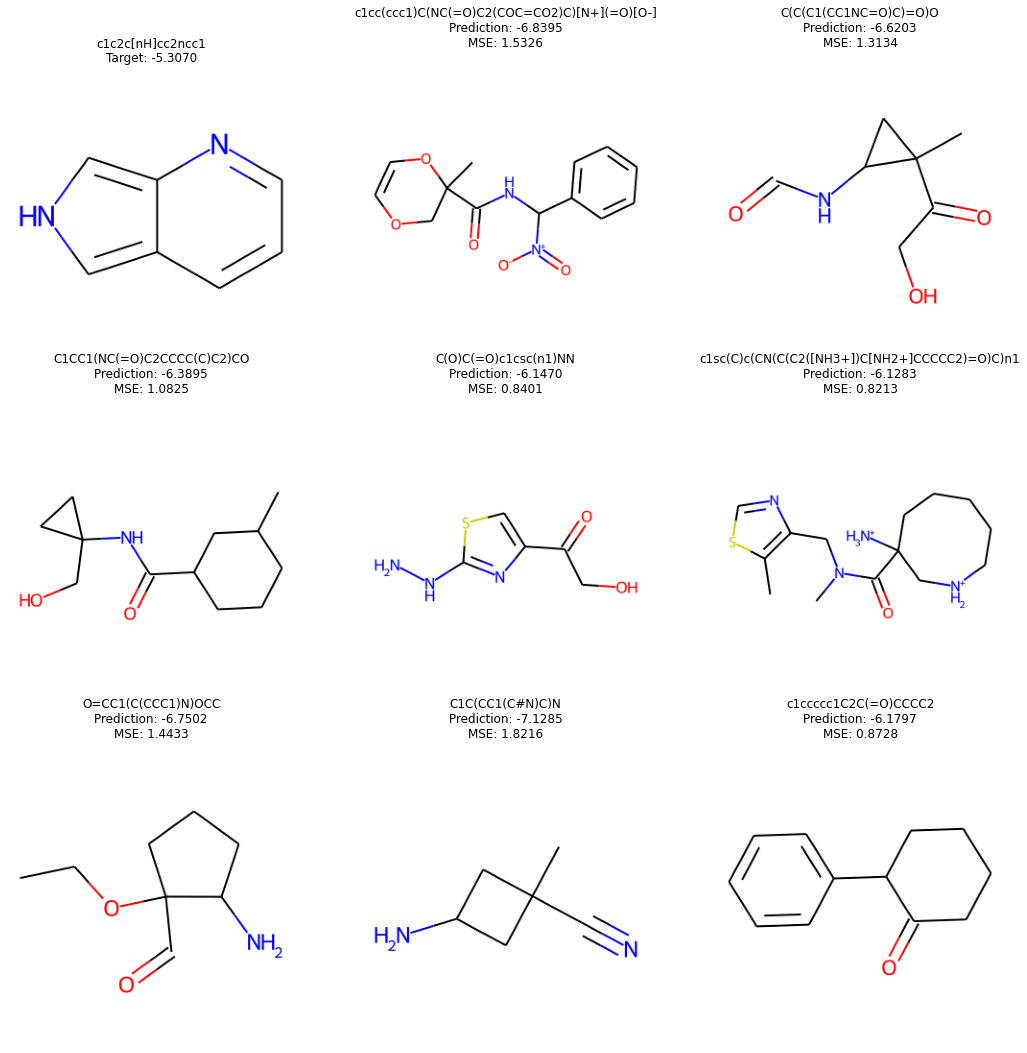

In [1162]:
pr = regressor(model.encode_latent_mean(list(success_map_2[51][0])))
visualise(list(success_map_2[51][0])[10:],
          k = 8,
          target_molecule = success_map_2[51][3].smiles,
          target_prop = regressor(success_map_2[51][2]).item(),
          predicted_props=pr.flatten().tolist()[10:])

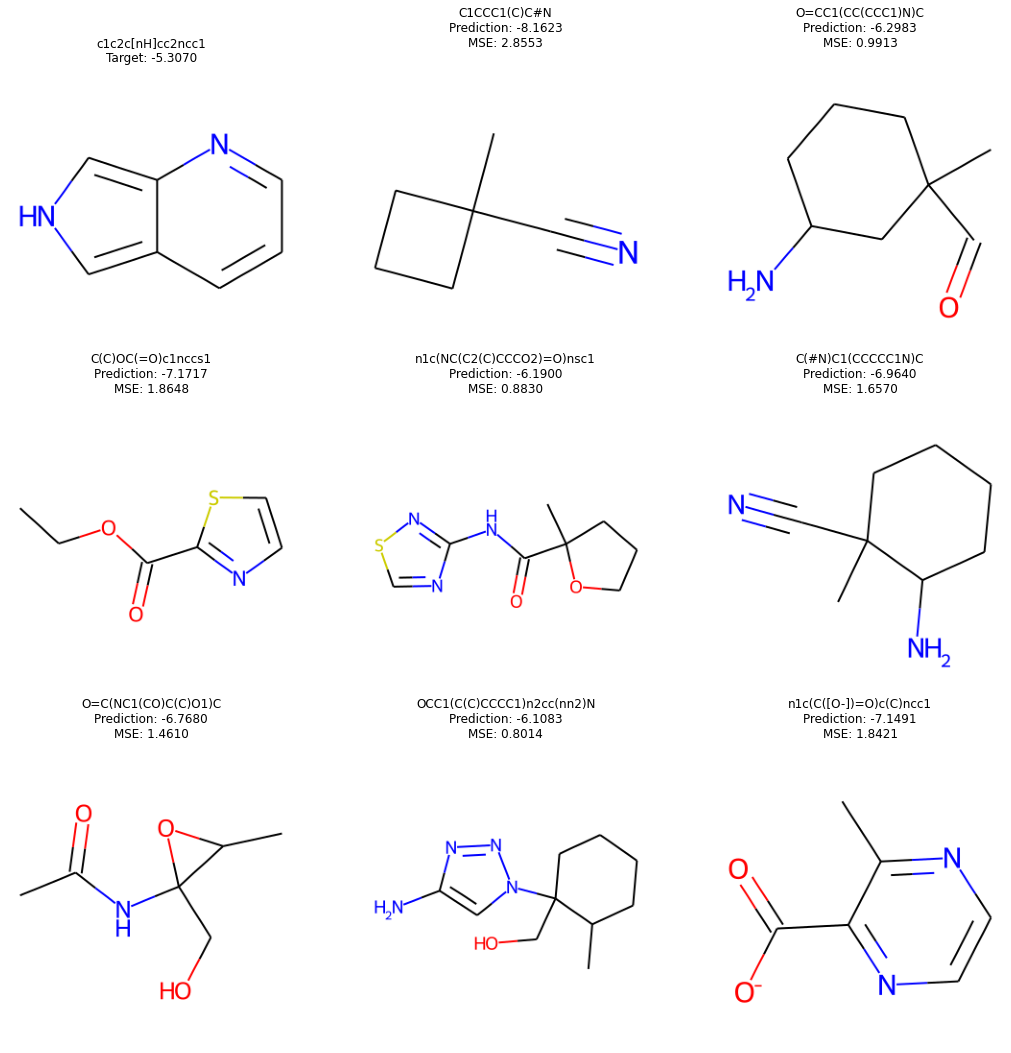

In [1161]:
pr = regressor(model.encode_latent_mean(list(success_map_2[51][0])))
visualise(list(success_map_2[51][0])[20:],
          k = 8,
          target_molecule = success_map_2[51][3].smiles,
          target_prop = regressor(success_map_2[51][2]).item(),
          predicted_props=pr.flatten().tolist()[20:])

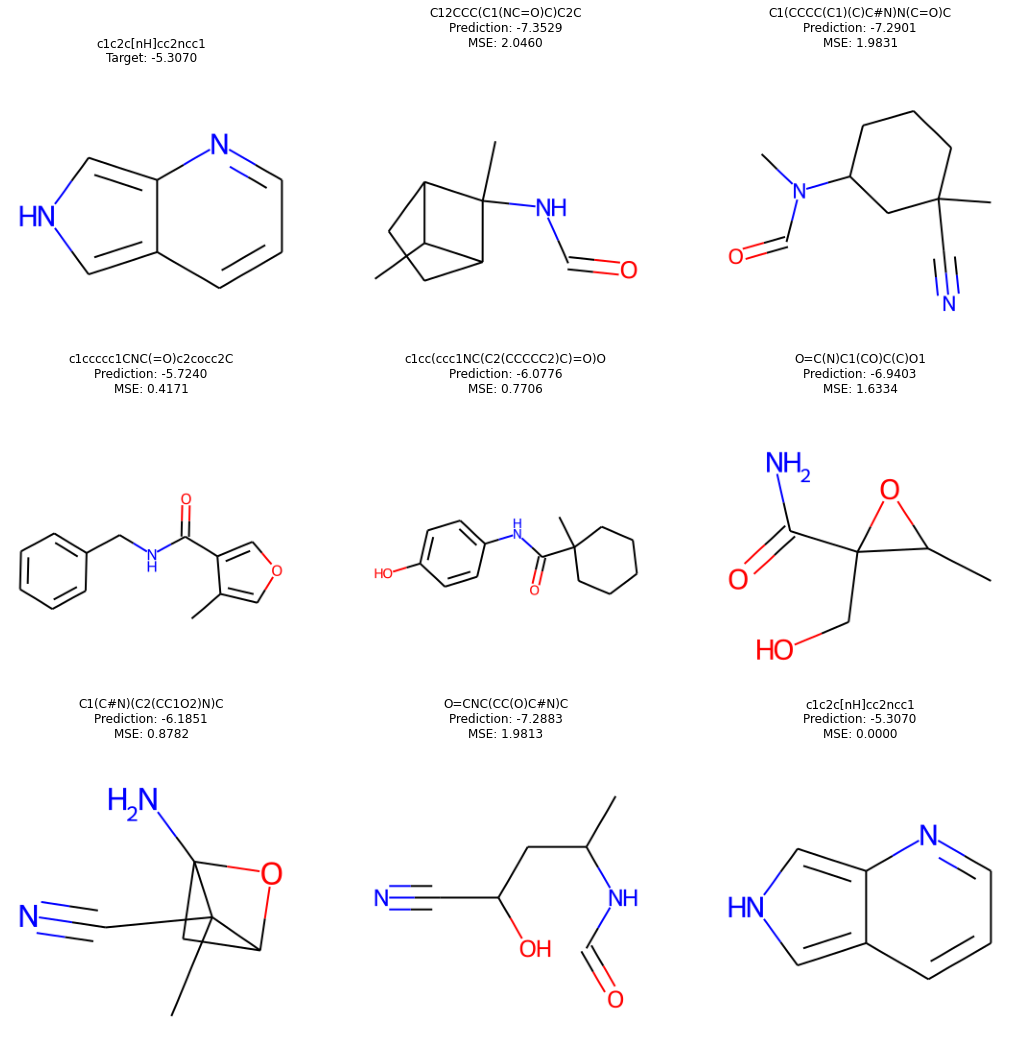

In [1164]:
pr = regressor(model.encode_latent_mean(list(success_map_2[51][0])))
visualise(list(success_map_2[51][0])[30:],
          k = 8,
          target_molecule = success_map_2[51][3].smiles,
          target_prop = regressor(success_map_2[51][2]).item(),
          predicted_props=pr.flatten().tolist()[30:])

## Reconstruction from Article

In [ ]:
"Molecule c1c2ccccc2co1, predicted value: -5.757090091705322, real value: -5.25, difference: 0.5070900917053223"
"Molecule c1c2c3ccccc3c4cocc4c2ccc1, predicted value: -5.630673885345459, real value: -5.51, difference: 0.1206738853454592"
"Molecule c12c3c4cccc3ccc1cccc2c5cocc45, predicted value: -5.522493839263916, real value: -5.54, difference: 0.01750616073608402"
"Molecule c1cc2cc3c(cc2cc1)ccc4c3coc4, predicted value: -4.917288303375244, real value: -5.39, difference: 0.47271169662475554"
"Molecule c12ccccc1ccc3c2coc3, predicted value: -5.673248767852783, real value: -5.39, difference: 0.2832487678527835"
"Molecule c1cccc2c1c3c(ccc4cocc34)cc2, predicted value: -5.381400108337402, real value: -5.27, difference: 0.11140010833740277"
"Molecule c1c2c(c3c(cccc3)c1)ccc4cocc24, predicted value: -6.051238059997559, real value: -5.22, difference: 0.8312380599975588"
"Molecule c12cocc1cc3ccc4cccc5ccc2c3c45, predicted value: -5.743382453918457, real value: -4.86, difference: 0.8833824539184567"
"Molecule c12ccc3c(cc4cocc4c3)c1cccc2, predicted value: -5.641488552093506, real value: -4.91, difference: 0.7314885520935057"
"Molecule c12c3ccc4c(cc5cocc5c4)c3ccc1cccc2, predicted value: -5.2047438621521, real value: -4.84, difference: 0.36474386215209975"
"Molecule c12c(cccc1)cc3cocc3c2, predicted value: -5.534309387207031, real value: -4.78, difference: 0.754309387207031"
"Molecule c12c(cc3c(cccc3)c1)cc4c(c2)coc4, predicted value: -6.212608337402344, real value: -4.48, difference: 1.7326083374023433"

In [1184]:
success_map_2[0][3].smiles in success_map_2[0][0]

True

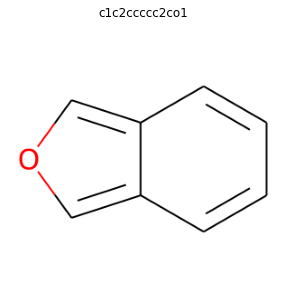

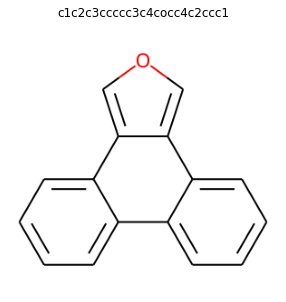

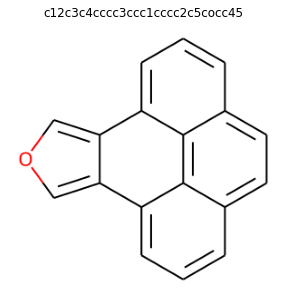

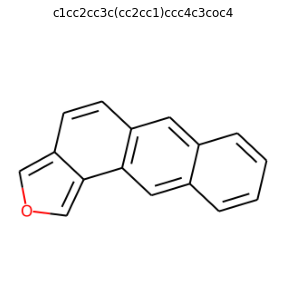

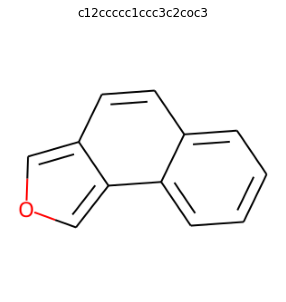

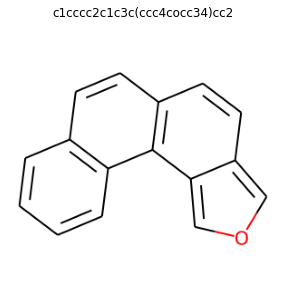

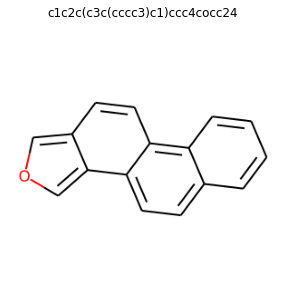

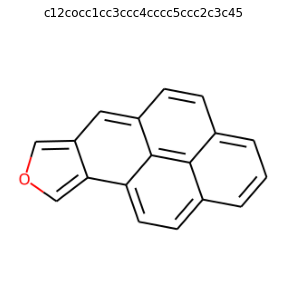

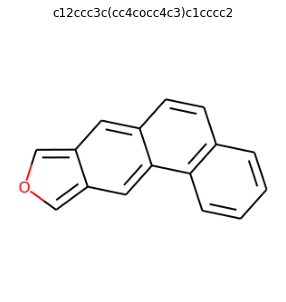

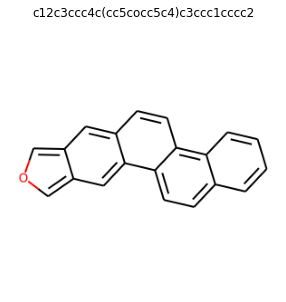

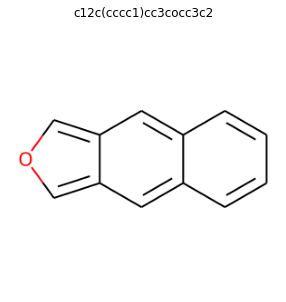

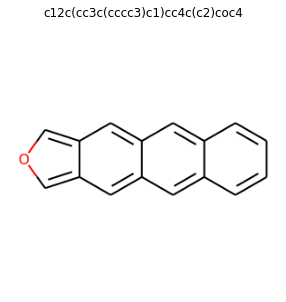

In [1167]:
for line in ["Molecule c1c2ccccc2co1, predicted value: -5.757090091705322, real value: -5.25, difference: 0.5070900917053223",
"Molecule c1c2c3ccccc3c4cocc4c2ccc1, predicted value: -5.630673885345459, real value: -5.51, difference: 0.1206738853454592",
"Molecule c12c3c4cccc3ccc1cccc2c5cocc45, predicted value: -5.522493839263916, real value: -5.54, difference: 0.01750616073608402",
"Molecule c1cc2cc3c(cc2cc1)ccc4c3coc4, predicted value: -4.917288303375244, real value: -5.39, difference: 0.47271169662475554",
"Molecule c12ccccc1ccc3c2coc3, predicted value: -5.673248767852783, real value: -5.39, difference: 0.2832487678527835",
"Molecule c1cccc2c1c3c(ccc4cocc34)cc2, predicted value: -5.381400108337402, real value: -5.27, difference: 0.11140010833740277",
"Molecule c1c2c(c3c(cccc3)c1)ccc4cocc24, predicted value: -6.051238059997559, real value: -5.22, difference: 0.8312380599975588",
"Molecule c12cocc1cc3ccc4cccc5ccc2c3c45, predicted value: -5.743382453918457, real value: -4.86, difference: 0.8833824539184567",
"Molecule c12ccc3c(cc4cocc4c3)c1cccc2, predicted value: -5.641488552093506, real value: -4.91, difference: 0.7314885520935057",
"Molecule c12c3ccc4c(cc5cocc5c4)c3ccc1cccc2, predicted value: -5.2047438621521, real value: -4.84, difference: 0.36474386215209975",
"Molecule c12c(cccc1)cc3cocc3c2, predicted value: -5.534309387207031, real value: -4.78, difference: 0.754309387207031",
"Molecule c12c(cc3c(cccc3)c1)cc4c(c2)coc4, predicted value: -6.212608337402344, real value: -4.48, difference: 1.7326083374023433"]:
    
    line = line.split(',')
    #gt.append(float(line[2].split(":")[1]))
    #pr.append(float(line[1].split(":")[1]))
    #diff.append(abs(gt[-1] - pr[-1]))

    img = Chem.Draw.MolToImage(Chem.MolFromSmiles(line[0].split(" ")[1]))
    plt.figure(figsize=(15, 5))
    plt.imshow(img)
    plt.title(line[0].split(" ")[1])
    plt.axis("off")
    plt.show()